In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from tensorflow import set_random_seed
set_random_seed(12)

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaco

# Preprocessing

In [2]:
data = pd.read_csv('./datasets/IBM_daily.csv').sort_values(by='date')

In [3]:
data

,date,1. open,2. high,3. low,4. close,5. volume
5217,1999-11-01,98.50,98.8100,96.37,96.75,9551800.0
5216,1999-11-02,96.75,96.8100,93.69,94.81,11105400.0
5215,1999-11-03,95.87,95.9400,93.50,94.37,10369100.0
5214,1999-11-04,94.44,94.4400,90.00,91.56,16697600.0
5213,1999-11-05,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...,...
4,2020-07-22,125.90,129.4700,125.80,128.67,8195366.0
3,2020-07-23,129.10,129.3700,127.15,127.33,4220136.0
2,2020-07-24,126.48,127.6459,125.50,125.79,3531076.0
1,2020-07-27,124.86,126.3200,124.71,126.21,3733547.0


In [4]:
data = data.drop(columns='date')
data

,1. open,2. high,3. low,4. close,5. volume
5217,98.50,98.8100,96.37,96.75,9551800.0
5216,96.75,96.8100,93.69,94.81,11105400.0
5215,95.87,95.9400,93.50,94.37,10369100.0
5214,94.44,94.4400,90.00,91.56,16697600.0
5213,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...
4,125.90,129.4700,125.80,128.67,8195366.0
3,129.10,129.3700,127.15,127.33,4220136.0
2,126.48,127.6459,125.50,125.79,3531076.0
1,124.86,126.3200,124.71,126.21,3733547.0


In [5]:
# Sequence for the LSTM network
backlook = 92

# Size of data split for testing
train_size = 0.8

In [6]:
# Normalise data
normaliser = preprocessing.MinMaxScaler()
data_norm = normaliser.fit_transform(data)

In [7]:
# Normalised chunks
historical_sequences_norm = np.array([data_norm[i : i + backlook].copy() for i in range(len(data_norm) - backlook)])
next_day_open_values_norm = np.array([data_norm[:,0][i + backlook].copy() for i in range(len(data_norm) - backlook)])
next_day_open_values_norm = np.expand_dims(next_day_open_values_norm, -1)

In [8]:
# Y raw data
next_day_open_values = np.array([data.to_numpy()[:,0][i + backlook].copy() for i in range(len(data) - backlook)])
next_day_open_values = np.expand_dims(next_day_open_values, -1)

# Y normaliser
y_normaliser = preprocessing.MinMaxScaler()
y_normaliser.fit_transform(next_day_open_values)

array([[0.3303677 ],
       [0.32881229],
       [0.33814471],
       ...,
       [0.44689853],
       [0.43681951],
       [0.44279226]])

In [9]:
# Train-Test split
split = int(historical_sequences_norm.shape[0] * train_size)

X_train = historical_sequences_norm[:split]
Y_train = next_day_open_values_norm[:split]

X_test = historical_sequences_norm[split:]
Y_test = next_day_open_values_norm[split:]
unscaled_y_test = next_day_open_values[split:]

# Model selection

##### Model constructor

In [10]:
def build_lstm(x, y, batch_size=512, epochs=24, **params):
    
    # List of parameters
    if 'lstmsize' not in params: params['lstmsize'] = x.shape[1]
    if 'density' not in params: params['density'] = int((params['lstmsize']//1.5)*2)
    if 'activation' not in params: params['activation'] = 'relu'
    if 'twice' not in params: params['twice'] = False
    if 'optimizer' not in params: params['optimizer'] = 'adam'
    if 'shuffle' not in params: params['shuffle'] = False
    
    # Model definition
    model = Sequential()
    
    model.add(LSTM(params['lstmsize'], input_shape=x.shape[1:], return_sequences=params['twice']))
    
    if 'dropout' in params:
        model.add(Dropout(params['dropout']))
    
    if params['twice']:
        model.add(LSTM(params['lstmsize']))
        
        if 'dropout' in params:
            model.add(Dropout(params['dropout']))
            
    model.add(Dense(params['density'], activation=params['activation']))
    
    if 'full_density' in params and params['full_density']:
        density = params['density']//2
        while density >= 12:
            model.add(Dense(density, activation=params['activation']))
            density //= 2
            
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mse', optimizer=params['optimizer'])
    
    if 'callbacks' in params:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'],
                            callbacks=params['callbacks'])
    else:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'])
    
    return [model, callback, params]

##### Evolutive algorith to search for the most optimal model

In [11]:
def set_genes(x, y, population_size, population=[]):
    if population_size-len(population) < 0:
        print('population size must be greater or equal than actual population')
        return
    
    if len(population) > 0:
        if len(population) < 3:
            print('population should be empty or 3 at least')
            return
        
        population[2] = breed_genes(x, y, population[0][2].copy())
        population[1] = breed_genes(x, y, combine=(population[0][2], population[1][2]))
        population = population[:3]
    
    for _ in range(population_size-len(population)):
        subject = breed_genes(x, y)
        population.append(subject)
        
    return population

def breed_genes(x, y, genes={}, combine=None):
    genes['x'] = x
    genes['y'] = y
    
    if type(combine) is list or type(combine) is tuple:
        genes['lstmsize'] = combine[np.random.randint(0,2)]['lstmsize']
        genes['density'] = combine[np.random.randint(0,2)]['density']
        genes['activation'] = combine[np.random.randint(0,2)]['activation']
        genes['twice'] = combine[np.random.randint(0,2)]['twice']
        genes['optimizer'] = combine[np.random.randint(0,2)]['optimizer']
        genes['shuffle'] = combine[np.random.randint(0,2)]['shuffle']
        
        genes['dropout'] = combine[np.random.randint(0,2)].get('dropout')
        if genes['dropout'] is None: del genes['dropout']
        genes['full_density'] = combine[np.random.randint(0,2)].get('full_density')
        if genes['full_density'] is None: del genes['full_density']
            
    else:
        if np.random.randint(0,3) == 1:
            genes['lstmsize'] = int((np.random.randint(x.shape[1],x.shape[1]*2)//2)*2)

        if np.random.randint(0,3) == 1:
            genes['density'] = int((np.random.randint(x.shape[1]//2,x.shape[1]*2.66)//2)*2)

        if np.random.randint(0,3) == 1:
            activation = [
                'relu',
                'sigmoid',
                'softplus',
                'softsign',
                'tanh',
                'selu',
                'elu',
                'exponential'
            ]
            genes['activation'] = activation[np.random.randint(0,8)]

        if np.random.randint(0,3) == 1:
            genes['twice'] = True

        if np.random.randint(0,3) == 1:
            optimizer = [
                'sgd',
                'rmsprop',
                'adam',
                'adadelta',
                'adagrad',
                'adamax',
                'nadam'
            ]
            genes['optimizer'] = optimizer[np.random.randint(0,7)]

        if np.random.randint(0,3) == 1:
            genes['shuffle'] = True

        if np.random.randint(0,3) == 1:
            genes['dropout'] = np.random.randint(1,4)/10

        if np.random.randint(0,3) == 1:
            genes['full_density'] = True
            
    new_model = build_lstm(**genes)
        
    return new_model

In [12]:
def breed_population(x, y, generations, population_size, population=[]):
    
    if generations > 1 and population_size < 3:
        print('population size should be of a minimum of 3 for more than one generation')
        return
    
    for g in range(generations):
        print(f'\nGENERATION {g}\n')
        population = set_genes(x, y, population_size, population)
        population = sorted(population, key=lambda x: x[1].history['val_loss'][-1]+x[1].history['loss'][-1])
        
    return population

In [13]:
best_models = breed_population(X_train, Y_train, generations=20, population_size=10)


GENERATION 0

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 2s 408us/step - loss: 0.1251 - val_loss: 0.0017
Epoch 2/24
3690/3690 [==============================] - 1s 159us/step - loss: 0.0058 - val_loss: 0.0020
Epoch 3/24
3690/3690 [==============================] - 1s 159us/step - loss: 0.0032 - val_loss: 0.0031
Epoch 4/24
3690/3690 [==============================] - 1s 162us/step - loss: 0.0037 - val_loss: 6.2091e-04
Epoch 5/24
3690/3690 [==============================] - 1s 160us/step - loss: 0.0021 - val_loss: 0.0013
Epoch 6/24
3690/3690 [==============================] - 1s 159us/step - loss: 0.0035 - val_loss: 0.0018
Epoch 7/24
3690/3690 [==============================] - 1s 161us/step - loss: 0.0025 - val_loss: 0.0063
Epoch 8/24
3690/3690 [==============================] - 1s 159us/step - loss: 0.0045 -

3690/3690 [==============================] - 1s 339us/step - loss: 0.0111 - val_loss: 0.0024
Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 2s 540us/step - loss: 0.0387 - val_loss: 0.0065
Epoch 2/24
3690/3690 [==============================] - 1s 343us/step - loss: 0.0164 - val_loss: 0.0040
Epoch 3/24
3690/3690 [==============================] - 1s 356us/step - loss: 0.0122 - val_loss: 0.0015
Epoch 4/24
3690/3690 [==============================] - 1s 364us/step - loss: 0.0084 - val_loss: 0.0011
Epoch 5/24
3690/3690 [==============================] - 1s 331us/step - loss: 0.0068 - val_loss: 7.8017e-04
Epoch 6/24
3690/3690 [==============================] - 1s 329us/step - loss: 0.0054 - val_loss: 6.3327e-04
Epoch 7/24
3690/3690 [==============================] - 1s 328us/step - loss: 0.0051 - val_loss: 7.7232e-04
Epoch 8/24
3690/3690 [==============================] - 1s 325us/step - loss: 0.0045 - val_loss: 6.5197e-04
Epoch 9/24
3

3690/3690 [==============================] - 2s 568us/step - loss: 0.0559 - val_loss: 0.0278
Epoch 4/24
3690/3690 [==============================] - 2s 570us/step - loss: 0.0597 - val_loss: 0.0061
Epoch 5/24
3690/3690 [==============================] - 2s 571us/step - loss: 0.0409 - val_loss: 0.0016
Epoch 6/24
3690/3690 [==============================] - 2s 570us/step - loss: 0.0162 - val_loss: 0.0446
Epoch 7/24
3690/3690 [==============================] - 2s 570us/step - loss: 0.0116 - val_loss: 0.0057
Epoch 8/24
3690/3690 [==============================] - 2s 571us/step - loss: 0.0040 - val_loss: 0.0115
Epoch 9/24
3690/3690 [==============================] - 2s 569us/step - loss: 0.0040 - val_loss: 0.0175
Epoch 10/24
3690/3690 [==============================] - 2s 573us/step - loss: 0.0087 - val_loss: 0.0177
Epoch 11/24
3690/3690 [==============================] - 2s 569us/step - loss: 0.0046 - val_loss: 0.0065
Epoch 12/24
3690/3690 [==============================] - 2s 569us/step - 

3690/3690 [==============================] - 2s 539us/step - loss: 0.0012 - val_loss: 0.0019
Epoch 8/24
3690/3690 [==============================] - 2s 537us/step - loss: 0.0011 - val_loss: 0.0015
Epoch 9/24
3690/3690 [==============================] - 2s 537us/step - loss: 0.0011 - val_loss: 0.0028
Epoch 10/24
3690/3690 [==============================] - 2s 579us/step - loss: 0.0010 - val_loss: 0.0014
Epoch 11/24
3690/3690 [==============================] - 2s 548us/step - loss: 9.5952e-04 - val_loss: 0.0011
Epoch 12/24
3690/3690 [==============================] - 2s 570us/step - loss: 9.8709e-04 - val_loss: 0.0010
Epoch 13/24
3690/3690 [==============================] - 2s 572us/step - loss: 9.0943e-04 - val_loss: 8.9709e-04
Epoch 14/24
3690/3690 [==============================] - 2s 551us/step - loss: 8.8784e-04 - val_loss: 0.0016
Epoch 15/24
3690/3690 [==============================] - 2s 555us/step - loss: 9.4083e-04 - val_loss: 5.2854e-04
Epoch 16/24
3690/3690 [==================

Epoch 11/24
3690/3690 [==============================] - 2s 577us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 12/24
3690/3690 [==============================] - 2s 576us/step - loss: 0.0015 - val_loss: 6.8414e-04
Epoch 13/24
3690/3690 [==============================] - 2s 581us/step - loss: 0.0016 - val_loss: 0.0013
Epoch 14/24
3690/3690 [==============================] - 2s 579us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 15/24
3690/3690 [==============================] - 2s 579us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 16/24
3690/3690 [==============================] - 2s 578us/step - loss: 0.0013 - val_loss: 7.5550e-04
Epoch 17/24
3690/3690 [==============================] - 2s 577us/step - loss: 0.0014 - val_loss: 0.0014
Epoch 18/24
3690/3690 [==============================] - 2s 579us/step - loss: 0.0013 - val_loss: 6.5538e-04
Epoch 19/24
3690/3690 [==============================] - 2s 579us/step - loss: 0.0013 - val_loss: 7.4739e-04
Epoch 20/24
3690/3690 [================

3690/3690 [==============================] - 2s 563us/step - loss: 0.0679 - val_loss: 0.0378
Epoch 16/24
3690/3690 [==============================] - 2s 565us/step - loss: 0.0676 - val_loss: 0.0469
Epoch 17/24
3690/3690 [==============================] - 2s 563us/step - loss: 0.0668 - val_loss: 0.0421
Epoch 18/24
3690/3690 [==============================] - 2s 562us/step - loss: 0.0669 - val_loss: 0.0326
Epoch 19/24
3690/3690 [==============================] - 2s 564us/step - loss: 0.0672 - val_loss: 0.0437
Epoch 20/24
3690/3690 [==============================] - 2s 564us/step - loss: 0.0659 - val_loss: 0.0463
Epoch 21/24
3690/3690 [==============================] - 2s 564us/step - loss: 0.0664 - val_loss: 0.0487
Epoch 22/24
3690/3690 [==============================] - 2s 565us/step - loss: 0.0658 - val_loss: 0.0589
Epoch 23/24
3690/3690 [==============================] - 2s 563us/step - loss: 0.0594 - val_loss: 0.0094
Epoch 24/24
3690/3690 [==============================] - 2s 565us/s

Epoch 20/24
3690/3690 [==============================] - 2s 561us/step - loss: 0.0046 - val_loss: 0.0023
Epoch 21/24
3690/3690 [==============================] - 2s 563us/step - loss: 0.0035 - val_loss: 0.0041
Epoch 22/24
3690/3690 [==============================] - 2s 563us/step - loss: 0.0056 - val_loss: 0.0053
Epoch 23/24
3690/3690 [==============================] - 2s 562us/step - loss: 0.0047 - val_loss: 0.0031
Epoch 24/24
3690/3690 [==============================] - 2s 563us/step - loss: 0.0034 - val_loss: 0.0036

GENERATION 2

Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 4s 1ms/step - loss: 1.3517 - val_loss: 0.0780
Epoch 2/24
3690/3690 [==============================] - 2s 550us/step - loss: 0.0680 - val_loss: 0.1311
Epoch 3/24
3690/3690 [==============================] - 2s 549us/step - loss: 0.0665 - val_loss: 0.0381
Epoch 4/24
3690/3690 [==============================] - 2s 548us/step - loss: 0.0456 - val_loss: 0.0039

3690/3690 [==============================] - 2s 554us/step - loss: 0.0011 - val_loss: 5.9742e-04
Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 4s 1ms/step - loss: 1.1145 - val_loss: 0.0563
Epoch 2/24
3690/3690 [==============================] - 2s 557us/step - loss: 0.0646 - val_loss: 0.0230
Epoch 3/24
3690/3690 [==============================] - 2s 556us/step - loss: 0.0310 - val_loss: 0.0039
Epoch 4/24
3690/3690 [==============================] - 2s 548us/step - loss: 0.0085 - val_loss: 0.0026
Epoch 5/24
3690/3690 [==============================] - 2s 550us/step - loss: 0.0177 - val_loss: 8.1583e-04
Epoch 6/24
3690/3690 [==============================] - 2s 552us/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/24
3690/3690 [==============================] - 2s 552us/step - loss: 0.0025 - val_loss: 0.0019
Epoch 8/24
3690/3690 [==============================] - 2s 552us/step - loss: 0.0020 - val_loss: 0.0012
Epoch 9/24
3690/3690 [

3690/3690 [==============================] - 2s 586us/step - loss: 0.0683 - val_loss: 0.0391
Epoch 5/24
3690/3690 [==============================] - 2s 589us/step - loss: 0.0682 - val_loss: 0.0414
Epoch 6/24
3690/3690 [==============================] - 2s 585us/step - loss: 0.0683 - val_loss: 0.0366
Epoch 7/24
3690/3690 [==============================] - 2s 585us/step - loss: 0.0683 - val_loss: 0.0350
Epoch 8/24
3690/3690 [==============================] - 2s 589us/step - loss: 0.0683 - val_loss: 0.0383
Epoch 9/24
3690/3690 [==============================] - 2s 590us/step - loss: 0.0682 - val_loss: 0.0370
Epoch 10/24
3690/3690 [==============================] - 2s 587us/step - loss: 0.0683 - val_loss: 0.0361
Epoch 11/24
3690/3690 [==============================] - 2s 585us/step - loss: 0.0683 - val_loss: 0.0404
Epoch 12/24
3690/3690 [==============================] - 2s 588us/step - loss: 0.0683 - val_loss: 0.0390
Epoch 13/24
3690/3690 [==============================] - 2s 587us/step -

3690/3690 [==============================] - 2s 588us/step - loss: 0.0011 - val_loss: 6.2930e-04
Epoch 9/24
3690/3690 [==============================] - 2s 587us/step - loss: 0.0011 - val_loss: 9.6004e-04
Epoch 10/24
3690/3690 [==============================] - 2s 588us/step - loss: 9.8708e-04 - val_loss: 0.0011
Epoch 11/24
3690/3690 [==============================] - 2s 588us/step - loss: 0.0010 - val_loss: 0.0012
Epoch 12/24
3690/3690 [==============================] - 2s 591us/step - loss: 9.7349e-04 - val_loss: 0.0013
Epoch 13/24
3690/3690 [==============================] - 2s 590us/step - loss: 9.2553e-04 - val_loss: 0.0012
Epoch 14/24
3690/3690 [==============================] - 2s 591us/step - loss: 8.8039e-04 - val_loss: 0.0010
Epoch 15/24
3690/3690 [==============================] - 2s 593us/step - loss: 8.4967e-04 - val_loss: 8.9510e-04
Epoch 16/24
3690/3690 [==============================] - 2s 594us/step - loss: 9.2146e-04 - val_loss: 7.1408e-04
Epoch 17/24
3690/3690 [=====

3690/3690 [==============================] - 1s 382us/step - loss: nan - val_loss: nan
Epoch 13/24
3690/3690 [==============================] - 1s 385us/step - loss: nan - val_loss: nan
Epoch 14/24
3690/3690 [==============================] - 1s 388us/step - loss: nan - val_loss: nan
Epoch 15/24
3690/3690 [==============================] - 1s 385us/step - loss: nan - val_loss: nan
Epoch 16/24
3690/3690 [==============================] - 1s 382us/step - loss: nan - val_loss: nan
Epoch 17/24
3690/3690 [==============================] - 1s 383us/step - loss: nan - val_loss: nan
Epoch 18/24
3690/3690 [==============================] - 1s 385us/step - loss: nan - val_loss: nan
Epoch 19/24
3690/3690 [==============================] - 1s 384us/step - loss: nan - val_loss: nan
Epoch 20/24
3690/3690 [==============================] - 1s 383us/step - loss: nan - val_loss: nan
Epoch 21/24
3690/3690 [==============================] - 1s 382us/step - loss: nan - val_loss: nan
Epoch 22/24
3690/3690 

3690/3690 [==============================] - 1s 384us/step - loss: 0.0022 - val_loss: 0.0066
Epoch 18/24
3690/3690 [==============================] - 1s 384us/step - loss: 0.0031 - val_loss: 0.0064
Epoch 19/24
3690/3690 [==============================] - 1s 385us/step - loss: 0.0021 - val_loss: 0.0020
Epoch 20/24
3690/3690 [==============================] - 1s 387us/step - loss: 8.7492e-04 - val_loss: 0.0012
Epoch 21/24
3690/3690 [==============================] - 1s 385us/step - loss: 7.6245e-04 - val_loss: 4.0761e-04
Epoch 22/24
3690/3690 [==============================] - 1s 387us/step - loss: 0.0010 - val_loss: 0.0019
Epoch 23/24
3690/3690 [==============================] - 1s 385us/step - loss: 0.0041 - val_loss: 4.4992e-04
Epoch 24/24
3690/3690 [==============================] - 1s 386us/step - loss: 0.0013 - val_loss: 5.0590e-04
Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 5s 1ms/step - loss: 0.0779 - val_loss: 0.0101
Epo

3690/3690 [==============================] - 2s 582us/step - loss: 8.5818e-04 - val_loss: 7.0591e-04
Epoch 21/24
3690/3690 [==============================] - 2s 578us/step - loss: 7.7319e-04 - val_loss: 4.5916e-04
Epoch 22/24
3690/3690 [==============================] - 2s 577us/step - loss: 8.5472e-04 - val_loss: 5.3973e-04
Epoch 23/24
3690/3690 [==============================] - 2s 581us/step - loss: 8.7640e-04 - val_loss: 0.0010
Epoch 24/24
3690/3690 [==============================] - 2s 586us/step - loss: 8.3102e-04 - val_loss: 6.4350e-04
Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 6s 2ms/step - loss: 0.0726 - val_loss: 0.0138
Epoch 2/24
3690/3690 [==============================] - 2s 583us/step - loss: 0.0123 - val_loss: 0.0105
Epoch 3/24
3690/3690 [==============================] - 2s 581us/step - loss: 0.0048 - val_loss: 0.0113
Epoch 4/24
3690/3690 [==============================] - 2s 582us/step - loss: 0.0028 - val_los

Epoch 23/24
3690/3690 [==============================] - 2s 487us/step - loss: 0.0019 - val_loss: 6.9852e-04
Epoch 24/24
3690/3690 [==============================] - 2s 485us/step - loss: 0.0019 - val_loss: 7.2648e-04
Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 6s 2ms/step - loss: 1.7621 - val_loss: 0.0031
Epoch 2/24
3690/3690 [==============================] - 2s 485us/step - loss: 0.0103 - val_loss: 0.0014
Epoch 3/24
3690/3690 [==============================] - 2s 489us/step - loss: 0.0056 - val_loss: 0.0017
Epoch 4/24
3690/3690 [==============================] - 2s 487us/step - loss: 0.0044 - val_loss: 0.0016
Epoch 5/24
3690/3690 [==============================] - 2s 487us/step - loss: 0.0042 - val_loss: 0.0016
Epoch 6/24
3690/3690 [==============================] - 2s 486us/step - loss: 0.0039 - val_loss: 9.5527e-04
Epoch 7/24
3690/3690 [==============================] - 2s 486us/step - loss: 0.0037 - val_loss: 0.0010
Epoch

3690/3690 [==============================] - 2s 490us/step - loss: 0.0194 - val_loss: 0.0015
Epoch 3/24
3690/3690 [==============================] - 2s 489us/step - loss: 0.0046 - val_loss: 0.0014
Epoch 4/24
3690/3690 [==============================] - 2s 487us/step - loss: 0.0028 - val_loss: 0.0030
Epoch 5/24
3690/3690 [==============================] - 2s 491us/step - loss: 0.0022 - val_loss: 0.0040
Epoch 6/24
3690/3690 [==============================] - 2s 491us/step - loss: 0.0024 - val_loss: 0.0066
Epoch 7/24
3690/3690 [==============================] - 2s 489us/step - loss: 0.0028 - val_loss: 0.0088
Epoch 8/24
3690/3690 [==============================] - 2s 487us/step - loss: 0.0028 - val_loss: 0.0041
Epoch 9/24
3690/3690 [==============================] - 2s 489us/step - loss: 0.0019 - val_loss: 0.0037
Epoch 10/24
3690/3690 [==============================] - 2s 488us/step - loss: 0.0018 - val_loss: 0.0039
Epoch 11/24
3690/3690 [==============================] - 2s 488us/step - l

3690/3690 [==============================] - 2s 583us/step - loss: 0.0017 - val_loss: 0.0014
Epoch 7/24
3690/3690 [==============================] - 2s 581us/step - loss: 0.0014 - val_loss: 0.0020
Epoch 8/24
3690/3690 [==============================] - 2s 581us/step - loss: 0.0013 - val_loss: 0.0022
Epoch 9/24
3690/3690 [==============================] - 2s 578us/step - loss: 0.0013 - val_loss: 0.0019
Epoch 10/24
3690/3690 [==============================] - 2s 581us/step - loss: 0.0012 - val_loss: 0.0015
Epoch 11/24
3690/3690 [==============================] - 2s 584us/step - loss: 0.0011 - val_loss: 0.0014
Epoch 12/24
3690/3690 [==============================] - 2s 585us/step - loss: 0.0011 - val_loss: 0.0014
Epoch 13/24
3690/3690 [==============================] - 2s 579us/step - loss: 0.0011 - val_loss: 6.3381e-04
Epoch 14/24
3690/3690 [==============================] - 2s 582us/step - loss: 0.0010 - val_loss: 5.9803e-04
Epoch 15/24
3690/3690 [==============================] - 2s 58

Epoch 10/24
3690/3690 [==============================] - 2s 492us/step - loss: 0.0104 - val_loss: 0.0142
Epoch 11/24
3690/3690 [==============================] - 2s 490us/step - loss: 0.0083 - val_loss: 0.0138
Epoch 12/24
3690/3690 [==============================] - 2s 489us/step - loss: 0.0080 - val_loss: 0.0034
Epoch 13/24
3690/3690 [==============================] - 2s 490us/step - loss: 0.0060 - val_loss: 0.0083
Epoch 14/24
3690/3690 [==============================] - 2s 491us/step - loss: 0.0064 - val_loss: 0.0047
Epoch 15/24
3690/3690 [==============================] - 2s 492us/step - loss: 0.0054 - val_loss: 0.0013
Epoch 16/24
3690/3690 [==============================] - 2s 493us/step - loss: 0.0075 - val_loss: 0.0036
Epoch 17/24
3690/3690 [==============================] - 2s 495us/step - loss: 0.0072 - val_loss: 0.0091
Epoch 18/24
3690/3690 [==============================] - 2s 490us/step - loss: 0.0074 - val_loss: 0.0056
Epoch 19/24
3690/3690 [==============================] 

3690/3690 [==============================] - 2s 504us/step - loss: 0.0096 - val_loss: 0.0027
Epoch 15/24
3690/3690 [==============================] - 2s 505us/step - loss: 0.0046 - val_loss: 0.0033
Epoch 16/24
3690/3690 [==============================] - 2s 504us/step - loss: 0.0057 - val_loss: 0.0104
Epoch 17/24
3690/3690 [==============================] - 2s 503us/step - loss: 0.0095 - val_loss: 0.0031
Epoch 18/24
3690/3690 [==============================] - 2s 502us/step - loss: 0.0063 - val_loss: 0.0063
Epoch 19/24
3690/3690 [==============================] - 2s 503us/step - loss: 0.0062 - val_loss: 0.0032
Epoch 20/24
3690/3690 [==============================] - 2s 503us/step - loss: 0.0049 - val_loss: 0.0020
Epoch 21/24
3690/3690 [==============================] - 2s 502us/step - loss: 0.0034 - val_loss: 9.6459e-04
Epoch 22/24
3690/3690 [==============================] - 2s 506us/step - loss: 0.0031 - val_loss: 0.0024
Epoch 23/24
3690/3690 [==============================] - 2s 504

3690/3690 [==============================] - 2s 586us/step - loss: 0.0623 - val_loss: 0.0378
Epoch 19/24
3690/3690 [==============================] - 2s 587us/step - loss: 0.0541 - val_loss: 0.0245
Epoch 20/24
3690/3690 [==============================] - 2s 591us/step - loss: 0.0386 - val_loss: 0.0146
Epoch 21/24
3690/3690 [==============================] - 2s 586us/step - loss: 0.0196 - val_loss: 0.0081
Epoch 22/24
3690/3690 [==============================] - 2s 586us/step - loss: 0.0110 - val_loss: 0.0190
Epoch 23/24
3690/3690 [==============================] - 2s 585us/step - loss: 0.0063 - val_loss: 0.0163
Epoch 24/24
3690/3690 [==============================] - 2s 585us/step - loss: 0.0045 - val_loss: 0.0055
Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 8s 2ms/step - loss: 0.0789 - val_loss: 0.0260
Epoch 2/24
3690/3690 [==============================] - 2s 586us/step - loss: 0.0131 - val_loss: 0.0064
Epoch 3/24
3690/3690 [==

Epoch 22/24
3690/3690 [==============================] - 2s 590us/step - loss: 0.0030 - val_loss: 0.0014
Epoch 23/24
3690/3690 [==============================] - 2s 586us/step - loss: 0.0029 - val_loss: 0.0014
Epoch 24/24
3690/3690 [==============================] - 2s 586us/step - loss: 0.0028 - val_loss: 0.0012
Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 9s 2ms/step - loss: 12.0756 - val_loss: 0.1646
Epoch 2/24
3690/3690 [==============================] - 2s 534us/step - loss: 0.0705 - val_loss: 0.0064
Epoch 3/24
3690/3690 [==============================] - 2s 535us/step - loss: 0.0230 - val_loss: 0.0036
Epoch 4/24
3690/3690 [==============================] - 2s 537us/step - loss: 0.0168 - val_loss: 0.0054
Epoch 5/24
3690/3690 [==============================] - 2s 534us/step - loss: 0.0137 - val_loss: 0.0031
Epoch 6/24
3690/3690 [==============================] - 2s 533us/step - loss: 0.0119 - val_loss: 0.0068
Epoch 7/24
3690

3690/3690 [==============================] - 2s 543us/step - loss: 0.0190 - val_loss: 0.0030
Epoch 3/24
3690/3690 [==============================] - 2s 544us/step - loss: 0.0055 - val_loss: 0.0016
Epoch 4/24
3690/3690 [==============================] - 2s 544us/step - loss: 0.0047 - val_loss: 0.0010
Epoch 5/24
3690/3690 [==============================] - 2s 542us/step - loss: 0.0044 - val_loss: 0.0029
Epoch 6/24
3690/3690 [==============================] - 2s 544us/step - loss: 0.0040 - val_loss: 0.0036
Epoch 7/24
3690/3690 [==============================] - 2s 541us/step - loss: 0.0039 - val_loss: 0.0030
Epoch 8/24
3690/3690 [==============================] - 2s 541us/step - loss: 0.0036 - val_loss: 0.0014
Epoch 9/24
3690/3690 [==============================] - 2s 544us/step - loss: 0.0033 - val_loss: 0.0015
Epoch 10/24
3690/3690 [==============================] - 2s 548us/step - loss: 0.0031 - val_loss: 0.0018
Epoch 11/24
3690/3690 [==============================] - 2s 545us/step - l

3690/3690 [==============================] - 2s 563us/step - loss: 0.0027 - val_loss: 0.0033
Epoch 6/24
3690/3690 [==============================] - 2s 559us/step - loss: 0.0021 - val_loss: 0.0040
Epoch 7/24
3690/3690 [==============================] - 2s 564us/step - loss: 0.0018 - val_loss: 8.4854e-04
Epoch 8/24
3690/3690 [==============================] - 2s 561us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 9/24
3690/3690 [==============================] - 2s 561us/step - loss: 0.0014 - val_loss: 0.0016
Epoch 10/24
3690/3690 [==============================] - 2s 565us/step - loss: 0.0012 - val_loss: 0.0018
Epoch 11/24
3690/3690 [==============================] - 2s 566us/step - loss: 0.0012 - val_loss: 0.0010
Epoch 12/24
3690/3690 [==============================] - 2s 561us/step - loss: 0.0011 - val_loss: 8.4257e-04
Epoch 13/24
3690/3690 [==============================] - 2s 563us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 14/24
3690/3690 [==============================] - 2s 559

3690/3690 [==============================] - 2s 564us/step - loss: 8.6943e-04 - val_loss: 7.4147e-04
Epoch 11/24
3690/3690 [==============================] - 2s 564us/step - loss: 8.4709e-04 - val_loss: 7.6401e-04
Epoch 12/24
3690/3690 [==============================] - 2s 564us/step - loss: 8.1009e-04 - val_loss: 8.0433e-04
Epoch 13/24
3690/3690 [==============================] - 2s 562us/step - loss: 7.9261e-04 - val_loss: 8.4480e-04
Epoch 14/24
3690/3690 [==============================] - 2s 561us/step - loss: 7.9040e-04 - val_loss: 8.2205e-04
Epoch 15/24
3690/3690 [==============================] - 2s 564us/step - loss: 7.7273e-04 - val_loss: 8.0828e-04
Epoch 16/24
3690/3690 [==============================] - 2s 568us/step - loss: 7.5293e-04 - val_loss: 7.5366e-04
Epoch 17/24
3690/3690 [==============================] - 2s 564us/step - loss: 7.4957e-04 - val_loss: 9.0613e-04
Epoch 18/24
3690/3690 [==============================] - 2s 564us/step - loss: 7.6768e-04 - val_loss: 8.7318

3690/3690 [==============================] - 2s 565us/step - loss: 0.0019 - val_loss: 0.0013
Epoch 14/24
3690/3690 [==============================] - 2s 563us/step - loss: 0.0018 - val_loss: 0.0011
Epoch 15/24
3690/3690 [==============================] - 2s 561us/step - loss: 0.0017 - val_loss: 0.0014
Epoch 16/24
3690/3690 [==============================] - 2s 564us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 17/24
3690/3690 [==============================] - 2s 563us/step - loss: 0.0017 - val_loss: 0.0011
Epoch 18/24
3690/3690 [==============================] - 2s 564us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 19/24
3690/3690 [==============================] - 2s 561us/step - loss: 0.0017 - val_loss: 0.0011
Epoch 20/24
3690/3690 [==============================] - 2s 563us/step - loss: 0.0017 - val_loss: 0.0011
Epoch 21/24
3690/3690 [==============================] - 2s 564us/step - loss: 0.0016 - val_loss: 0.0011
Epoch 22/24
3690/3690 [==============================] - 2s 562us/s

3690/3690 [==============================] - 1s 340us/step - loss: 0.0019 - val_loss: 0.0011
Epoch 18/24
3690/3690 [==============================] - 1s 343us/step - loss: 0.0017 - val_loss: 0.0012
Epoch 19/24
3690/3690 [==============================] - 1s 339us/step - loss: 0.0018 - val_loss: 9.7079e-04
Epoch 20/24
3690/3690 [==============================] - 1s 345us/step - loss: 0.0017 - val_loss: 9.2646e-04
Epoch 21/24
3690/3690 [==============================] - 1s 341us/step - loss: 0.0017 - val_loss: 0.0015
Epoch 22/24
3690/3690 [==============================] - 1s 342us/step - loss: 0.0017 - val_loss: 0.0011
Epoch 23/24
3690/3690 [==============================] - 1s 341us/step - loss: 0.0016 - val_loss: 9.4204e-04
Epoch 24/24
3690/3690 [==============================] - 1s 340us/step - loss: 0.0016 - val_loss: 9.4408e-04
Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 11s 3ms/step - loss: 0.6744 - val_loss: 0.5214
Epoch 

Epoch 22/24
3690/3690 [==============================] - 2s 490us/step - loss: 0.0018 - val_loss: 9.0329e-04
Epoch 23/24
3690/3690 [==============================] - 2s 492us/step - loss: 0.0018 - val_loss: 0.0037
Epoch 24/24
3690/3690 [==============================] - 2s 489us/step - loss: 0.0023 - val_loss: 0.0079
Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 12s 3ms/step - loss: 1.0436 - val_loss: 0.0675
Epoch 2/24
3690/3690 [==============================] - 2s 491us/step - loss: 0.0559 - val_loss: 0.0287
Epoch 3/24
3690/3690 [==============================] - 2s 490us/step - loss: 0.0316 - val_loss: 0.0245
Epoch 4/24
3690/3690 [==============================] - 2s 490us/step - loss: 0.0234 - val_loss: 0.0142
Epoch 5/24
3690/3690 [==============================] - 2s 494us/step - loss: 0.0151 - val_loss: 0.0055
Epoch 6/24
3690/3690 [==============================] - 2s 492us/step - loss: 0.0125 - val_loss: 0.0028
Epoch 7/24


3690/3690 [==============================] - 2s 588us/step - loss: 0.0107 - val_loss: 0.0071
Epoch 3/24
3690/3690 [==============================] - 2s 589us/step - loss: 0.0049 - val_loss: 0.0073
Epoch 4/24
3690/3690 [==============================] - 2s 586us/step - loss: 0.0038 - val_loss: 7.5542e-04
Epoch 5/24
3690/3690 [==============================] - 2s 591us/step - loss: 0.0026 - val_loss: 0.0041
Epoch 6/24
3690/3690 [==============================] - 2s 588us/step - loss: 0.0019 - val_loss: 0.0025
Epoch 7/24
3690/3690 [==============================] - 2s 585us/step - loss: 0.0015 - val_loss: 9.4827e-04
Epoch 8/24
3690/3690 [==============================] - 2s 586us/step - loss: 0.0012 - val_loss: 6.4377e-04
Epoch 9/24
3690/3690 [==============================] - 2s 587us/step - loss: 0.0011 - val_loss: 5.2220e-04
Epoch 10/24
3690/3690 [==============================] - 2s 585us/step - loss: 0.0011 - val_loss: 6.8270e-04
Epoch 11/24
3690/3690 [==============================]

3690/3690 [==============================] - 2s 429us/step - loss: 0.0051 - val_loss: 0.0027
Epoch 6/24
3690/3690 [==============================] - 2s 414us/step - loss: 0.0031 - val_loss: 0.0011
Epoch 7/24
3690/3690 [==============================] - 2s 414us/step - loss: 0.0031 - val_loss: 0.0032
Epoch 8/24
3690/3690 [==============================] - 2s 411us/step - loss: 0.0060 - val_loss: 0.0085
Epoch 9/24
3690/3690 [==============================] - 2s 411us/step - loss: 0.0059 - val_loss: 0.0027
Epoch 10/24
3690/3690 [==============================] - 2s 410us/step - loss: 0.0038 - val_loss: 0.0029
Epoch 11/24
3690/3690 [==============================] - 2s 412us/step - loss: 0.0039 - val_loss: 0.0046
Epoch 12/24
3690/3690 [==============================] - 2s 418us/step - loss: 0.0055 - val_loss: 0.0122
Epoch 13/24
3690/3690 [==============================] - 2s 410us/step - loss: 0.0054 - val_loss: 0.0044
Epoch 14/24
3690/3690 [==============================] - 2s 412us/step 

Epoch 10/24
3690/3690 [==============================] - 2s 532us/step - loss: 0.0030 - val_loss: 0.0052
Epoch 11/24
3690/3690 [==============================] - 2s 523us/step - loss: 0.0028 - val_loss: 0.0086
Epoch 12/24
3690/3690 [==============================] - 2s 524us/step - loss: 0.0067 - val_loss: 0.0115
Epoch 13/24
3690/3690 [==============================] - 2s 522us/step - loss: 0.0049 - val_loss: 0.0096
Epoch 14/24
3690/3690 [==============================] - 2s 524us/step - loss: 0.0045 - val_loss: 0.0087
Epoch 15/24
3690/3690 [==============================] - 2s 521us/step - loss: 0.0041 - val_loss: 0.0094
Epoch 16/24
3690/3690 [==============================] - 2s 522us/step - loss: 0.0039 - val_loss: 0.0082
Epoch 17/24
3690/3690 [==============================] - 2s 523us/step - loss: 0.0036 - val_loss: 0.0032
Epoch 18/24
3690/3690 [==============================] - 2s 523us/step - loss: 0.0022 - val_loss: 0.0042
Epoch 19/24
3690/3690 [==============================] 

3690/3690 [==============================] - 2s 601us/step - loss: 0.0014 - val_loss: 7.0731e-04
Epoch 15/24
3690/3690 [==============================] - 2s 604us/step - loss: 0.0013 - val_loss: 8.3683e-04
Epoch 16/24
3690/3690 [==============================] - 2s 604us/step - loss: 0.0013 - val_loss: 6.7450e-04
Epoch 17/24
3690/3690 [==============================] - 2s 605us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 18/24
3690/3690 [==============================] - 2s 603us/step - loss: 0.0013 - val_loss: 7.3179e-04
Epoch 19/24
3690/3690 [==============================] - 2s 606us/step - loss: 0.0011 - val_loss: 5.9198e-04
Epoch 20/24
3690/3690 [==============================] - 2s 603us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 21/24
3690/3690 [==============================] - 2s 602us/step - loss: 0.0012 - val_loss: 7.8772e-04
Epoch 22/24
3690/3690 [==============================] - 2s 602us/step - loss: 0.0010 - val_loss: 5.8783e-04
Epoch 23/24
3690/3690 [================

3690/3690 [==============================] - 2s 576us/step - loss: 46.7773 - val_loss: 42.7771
Epoch 17/24
3690/3690 [==============================] - 2s 578us/step - loss: 45.2671 - val_loss: 39.5644
Epoch 18/24
3690/3690 [==============================] - 2s 579us/step - loss: 42.8685 - val_loss: 36.6601
Epoch 19/24
3690/3690 [==============================] - 2s 577us/step - loss: 41.1054 - val_loss: 34.0220
Epoch 20/24
3690/3690 [==============================] - 2s 578us/step - loss: 41.3266 - val_loss: 31.5055
Epoch 21/24
3690/3690 [==============================] - 2s 578us/step - loss: 39.1966 - val_loss: 28.9974
Epoch 22/24
3690/3690 [==============================] - 2s 578us/step - loss: 36.1183 - val_loss: 26.1719
Epoch 23/24
3690/3690 [==============================] - 2s 576us/step - loss: 36.6083 - val_loss: 21.9451
Epoch 24/24
3690/3690 [==============================] - 2s 579us/step - loss: 33.0790 - val_loss: 13.8381
Train on 3690 samples, validate on 410 samples
Ep

3690/3690 [==============================] - 18s 5ms/step - loss: nan - val_loss: nan
Epoch 2/24
3690/3690 [==============================] - 2s 578us/step - loss: nan - val_loss: nan
Epoch 3/24
3690/3690 [==============================] - 2s 579us/step - loss: nan - val_loss: nan
Epoch 4/24
3690/3690 [==============================] - 2s 574us/step - loss: nan - val_loss: nan
Epoch 5/24
3690/3690 [==============================] - 2s 578us/step - loss: nan - val_loss: nan
Epoch 6/24
3690/3690 [==============================] - 2s 578us/step - loss: nan - val_loss: nan
Epoch 7/24
3690/3690 [==============================] - 2s 577us/step - loss: nan - val_loss: nan
Epoch 8/24
3690/3690 [==============================] - 2s 578us/step - loss: nan - val_loss: nan
Epoch 9/24
3690/3690 [==============================] - 2s 578us/step - loss: nan - val_loss: nan
Epoch 10/24
3690/3690 [==============================] - 2s 580us/step - loss: nan - val_loss: nan
Epoch 11/24
3690/3690 [========

Epoch 8/24
3690/3690 [==============================] - 2s 605us/step - loss: 0.0012 - val_loss: 5.4277e-04
Epoch 9/24
3690/3690 [==============================] - 2s 605us/step - loss: 0.0011 - val_loss: 6.2035e-04
Epoch 10/24
3690/3690 [==============================] - 2s 604us/step - loss: 0.0010 - val_loss: 6.2512e-04
Epoch 11/24
3690/3690 [==============================] - 2s 605us/step - loss: 9.9375e-04 - val_loss: 0.0013
Epoch 12/24
3690/3690 [==============================] - 2s 606us/step - loss: 9.8392e-04 - val_loss: 0.0016
Epoch 13/24
3690/3690 [==============================] - 2s 606us/step - loss: 0.0010 - val_loss: 0.0023
Epoch 14/24
3690/3690 [==============================] - 2s 605us/step - loss: 0.0010 - val_loss: 0.0012
Epoch 15/24
3690/3690 [==============================] - 2s 607us/step - loss: 9.0524e-04 - val_loss: 8.0679e-04
Epoch 16/24
3690/3690 [==============================] - 2s 609us/step - loss: 8.6341e-04 - val_loss: 6.6562e-04
Epoch 17/24
3690/3690

3690/3690 [==============================] - 2s 447us/step - loss: 0.0672 - val_loss: 0.0382
Epoch 11/24
3690/3690 [==============================] - 2s 447us/step - loss: 0.0655 - val_loss: 0.0305
Epoch 12/24
3690/3690 [==============================] - 2s 447us/step - loss: 0.0588 - val_loss: 0.0093
Epoch 13/24
3690/3690 [==============================] - 2s 445us/step - loss: 0.0703 - val_loss: 0.0566
Epoch 14/24
3690/3690 [==============================] - 2s 444us/step - loss: 0.0568 - val_loss: 0.0244
Epoch 15/24
3690/3690 [==============================] - 2s 446us/step - loss: 0.0187 - val_loss: 0.0383
Epoch 16/24
3690/3690 [==============================] - 2s 446us/step - loss: 0.0124 - val_loss: 0.0567
Epoch 17/24
3690/3690 [==============================] - 2s 445us/step - loss: 0.0893 - val_loss: 0.0071
Epoch 18/24
3690/3690 [==============================] - 2s 444us/step - loss: 0.0852 - val_loss: 0.1198
Epoch 19/24
3690/3690 [==============================] - 2s 443us/s

Epoch 15/24
3690/3690 [==============================] - 2s 539us/step - loss: 0.0052 - val_loss: 0.0076
Epoch 16/24
3690/3690 [==============================] - 2s 541us/step - loss: 0.0045 - val_loss: 0.0060
Epoch 17/24
3690/3690 [==============================] - 2s 539us/step - loss: 0.0049 - val_loss: 0.0086
Epoch 18/24
3690/3690 [==============================] - 2s 538us/step - loss: 0.0065 - val_loss: 0.0010
Epoch 19/24
3690/3690 [==============================] - 2s 536us/step - loss: 0.0042 - val_loss: 0.0011
Epoch 20/24
3690/3690 [==============================] - 2s 542us/step - loss: 0.0042 - val_loss: 0.0020
Epoch 21/24
3690/3690 [==============================] - 2s 538us/step - loss: 0.0037 - val_loss: 0.0082
Epoch 22/24
3690/3690 [==============================] - 2s 537us/step - loss: 0.0049 - val_loss: 0.0020
Epoch 23/24
3690/3690 [==============================] - 2s 538us/step - loss: 0.0041 - val_loss: 0.0014
Epoch 24/24
3690/3690 [==============================] 

3690/3690 [==============================] - 2s 521us/step - loss: 8.7308e-04 - val_loss: 4.1714e-04
Epoch 20/24
3690/3690 [==============================] - 2s 522us/step - loss: 8.4422e-04 - val_loss: 4.1839e-04
Epoch 21/24
3690/3690 [==============================] - 2s 523us/step - loss: 8.2048e-04 - val_loss: 5.2629e-04
Epoch 22/24
3690/3690 [==============================] - 2s 524us/step - loss: 7.5509e-04 - val_loss: 4.0564e-04
Epoch 23/24
3690/3690 [==============================] - 2s 519us/step - loss: 7.8497e-04 - val_loss: 3.7924e-04
Epoch 24/24
3690/3690 [==============================] - 2s 520us/step - loss: 7.7521e-04 - val_loss: 4.7637e-04
Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 22s 6ms/step - loss: 2.2146 - val_loss: 0.0200
Epoch 2/24
3690/3690 [==============================] - 2s 523us/step - loss: 0.1654 - val_loss: 0.0359
Epoch 3/24
3690/3690 [==============================] - 2s 520us/step - loss: 0.

Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 23s 6ms/step - loss: nan - val_loss: nan
Epoch 2/24
3690/3690 [==============================] - 2s 522us/step - loss: nan - val_loss: nan
Epoch 3/24
3690/3690 [==============================] - 2s 522us/step - loss: nan - val_loss: nan
Epoch 4/24
3690/3690 [==============================] - 2s 519us/step - loss: nan - val_loss: nan
Epoch 5/24
3690/3690 [==============================] - 2s 520us/step - loss: nan - val_loss: nan
Epoch 6/24
3690/3690 [==============================] - 2s 520us/step - loss: nan - val_loss: nan
Epoch 7/24
3690/3690 [==============================] - 2s 520us/step - loss: nan - val_loss: nan
Epoch 8/24
3690/3690 [==============================] - 2s 523us/step - loss: nan - val_loss: nan
Epoch 9/24
3690/3690 [==============================] - 2s 522us/step - loss: nan - val_loss: nan
Epoch 10/24
3690/3690 [==============================] - 2s 519us/step -

3690/3690 [==============================] - 2s 435us/step - loss: nan - val_loss: nan
Epoch 11/24
3690/3690 [==============================] - 2s 436us/step - loss: nan - val_loss: nan
Epoch 12/24
3690/3690 [==============================] - 2s 435us/step - loss: nan - val_loss: nan
Epoch 13/24
3690/3690 [==============================] - 2s 440us/step - loss: nan - val_loss: nan
Epoch 14/24
3690/3690 [==============================] - 2s 435us/step - loss: nan - val_loss: nan
Epoch 15/24
3690/3690 [==============================] - 2s 439us/step - loss: nan - val_loss: nan
Epoch 16/24
3690/3690 [==============================] - 2s 448us/step - loss: nan - val_loss: nan
Epoch 17/24
3690/3690 [==============================] - 2s 435us/step - loss: nan - val_loss: nan
Epoch 18/24
3690/3690 [==============================] - 2s 434us/step - loss: nan - val_loss: nan
Epoch 19/24
3690/3690 [==============================] - 2s 436us/step - loss: nan - val_loss: nan
Epoch 20/24
3690/3690 

3690/3690 [==============================] - 2s 523us/step - loss: 0.0013 - val_loss: 6.7290e-04
Epoch 15/24
3690/3690 [==============================] - 2s 520us/step - loss: 0.0012 - val_loss: 6.8460e-04
Epoch 16/24
3690/3690 [==============================] - 2s 524us/step - loss: 0.0012 - val_loss: 6.6587e-04
Epoch 17/24
3690/3690 [==============================] - 2s 524us/step - loss: 0.0012 - val_loss: 5.9076e-04
Epoch 18/24
3690/3690 [==============================] - 2s 525us/step - loss: 0.0011 - val_loss: 5.2210e-04
Epoch 19/24
3690/3690 [==============================] - 2s 524us/step - loss: 0.0011 - val_loss: 4.6488e-04
Epoch 20/24
3690/3690 [==============================] - 2s 521us/step - loss: 0.0011 - val_loss: 7.4703e-04
Epoch 21/24
3690/3690 [==============================] - 2s 525us/step - loss: 0.0010 - val_loss: 4.2469e-04
Epoch 22/24
3690/3690 [==============================] - 2s 523us/step - loss: 0.0010 - val_loss: 4.2590e-04
Epoch 23/24
3690/3690 [========

3690/3690 [==============================] - 2s 552us/step - loss: 0.0014 - val_loss: 0.0044
Epoch 18/24
3690/3690 [==============================] - 2s 552us/step - loss: 0.0013 - val_loss: 0.0034
Epoch 19/24
3690/3690 [==============================] - 2s 554us/step - loss: 0.0012 - val_loss: 0.0030
Epoch 20/24
3690/3690 [==============================] - 2s 549us/step - loss: 0.0012 - val_loss: 0.0020
Epoch 21/24
3690/3690 [==============================] - 2s 550us/step - loss: 0.0011 - val_loss: 0.0039
Epoch 22/24
3690/3690 [==============================] - 2s 552us/step - loss: 0.0011 - val_loss: 0.0041
Epoch 23/24
3690/3690 [==============================] - 2s 553us/step - loss: 0.0011 - val_loss: 0.0041
Epoch 24/24
3690/3690 [==============================] - 2s 552us/step - loss: 0.0010 - val_loss: 0.0058
Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 26s 7ms/step - loss: 0.1206 - val_loss: 0.0176
Epoch 2/24
3690/3690 [

Epoch 22/24
3690/3690 [==============================] - 2s 543us/step - loss: 0.0046 - val_loss: 0.0066
Epoch 23/24
3690/3690 [==============================] - 2s 545us/step - loss: 0.0040 - val_loss: 0.0085
Epoch 24/24
3690/3690 [==============================] - 2s 542us/step - loss: 0.0047 - val_loss: 0.0071

GENERATION 14

Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 28s 8ms/step - loss: 0.0801 - val_loss: 0.0037
Epoch 2/24
3690/3690 [==============================] - 2s 572us/step - loss: 0.0095 - val_loss: 0.0046
Epoch 3/24
3690/3690 [==============================] - 2s 572us/step - loss: 0.0064 - val_loss: 0.0140
Epoch 4/24
3690/3690 [==============================] - 2s 571us/step - loss: 0.0036 - val_loss: 5.6322e-04
Epoch 5/24
3690/3690 [==============================] - 2s 573us/step - loss: 0.0025 - val_loss: 0.0014
Epoch 6/24
3690/3690 [==============================] - 2s 574us/step - loss: 0.0020 - val_loss: 0.

Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 28s 8ms/step - loss: 0.0955 - val_loss: 0.0813
Epoch 2/24
3690/3690 [==============================] - 2s 516us/step - loss: 0.0686 - val_loss: 0.0320
Epoch 3/24
3690/3690 [==============================] - 2s 517us/step - loss: 0.0622 - val_loss: 0.0306
Epoch 4/24
3690/3690 [==============================] - 2s 517us/step - loss: 0.0538 - val_loss: 0.0046
Epoch 5/24
3690/3690 [==============================] - 2s 516us/step - loss: 0.0742 - val_loss: 0.0038
Epoch 6/24
3690/3690 [==============================] - 2s 517us/step - loss: 0.0390 - val_loss: 0.0223
Epoch 7/24
3690/3690 [==============================] - 2s 518us/step - loss: 0.0258 - val_loss: 0.0772
Epoch 8/24
3690/3690 [==============================] - 2s 519us/step - loss: 0.0191 - val_loss: 0.0270
Epoch 9/24
3690/3690 [==============================] - 2s 518us/step - loss: 0.0064 - val_loss: 0.0280
Epoch 10/24
3690/3

3690/3690 [==============================] - 2s 452us/step - loss: 0.0332 - val_loss: 0.0279
Epoch 6/24
3690/3690 [==============================] - 2s 452us/step - loss: 0.0310 - val_loss: 0.0141
Epoch 7/24
3690/3690 [==============================] - 2s 451us/step - loss: 0.0248 - val_loss: 0.0103
Epoch 8/24
3690/3690 [==============================] - 2s 452us/step - loss: 0.0223 - val_loss: 0.0101
Epoch 9/24
3690/3690 [==============================] - 2s 456us/step - loss: 0.0202 - val_loss: 0.0034
Epoch 10/24
3690/3690 [==============================] - 2s 452us/step - loss: 0.0137 - val_loss: 0.0111
Epoch 11/24
3690/3690 [==============================] - 2s 451us/step - loss: 0.0238 - val_loss: 0.0215
Epoch 12/24
3690/3690 [==============================] - 2s 449us/step - loss: 0.0195 - val_loss: 0.0072
Epoch 13/24
3690/3690 [==============================] - 2s 452us/step - loss: 0.0131 - val_loss: 0.0208
Epoch 14/24
3690/3690 [==============================] - 2s 452us/step 

Epoch 10/24
3690/3690 [==============================] - 2s 528us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 11/24
3690/3690 [==============================] - 2s 527us/step - loss: 0.0020 - val_loss: 0.0021
Epoch 12/24
3690/3690 [==============================] - 2s 524us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 13/24
3690/3690 [==============================] - 2s 524us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 14/24
3690/3690 [==============================] - 2s 529us/step - loss: 0.0016 - val_loss: 0.0016
Epoch 15/24
3690/3690 [==============================] - 2s 538us/step - loss: 0.0015 - val_loss: 0.0015
Epoch 16/24
3690/3690 [==============================] - 2s 537us/step - loss: 0.0015 - val_loss: 0.0021
Epoch 17/24
3690/3690 [==============================] - 2s 527us/step - loss: 0.0014 - val_loss: 8.0266e-04
Epoch 18/24
3690/3690 [==============================] - 2s 525us/step - loss: 0.0015 - val_loss: 0.0016
Epoch 19/24
3690/3690 [============================

3690/3690 [==============================] - 2s 543us/step - loss: 9.5985e-04 - val_loss: 6.0337e-04
Epoch 14/24
3690/3690 [==============================] - 2s 545us/step - loss: 9.6929e-04 - val_loss: 5.6426e-04
Epoch 15/24
3690/3690 [==============================] - 2s 549us/step - loss: 9.3956e-04 - val_loss: 5.3616e-04
Epoch 16/24
3690/3690 [==============================] - 2s 549us/step - loss: 9.5882e-04 - val_loss: 5.3094e-04
Epoch 17/24
3690/3690 [==============================] - 2s 544us/step - loss: 8.8169e-04 - val_loss: 7.3584e-04
Epoch 18/24
3690/3690 [==============================] - 2s 549us/step - loss: 8.5590e-04 - val_loss: 0.0013
Epoch 19/24
3690/3690 [==============================] - 2s 545us/step - loss: 9.1451e-04 - val_loss: 0.0012
Epoch 20/24
3690/3690 [==============================] - 2s 543us/step - loss: 8.9892e-04 - val_loss: 6.8614e-04
Epoch 21/24
3690/3690 [==============================] - 2s 545us/step - loss: 8.0422e-04 - val_loss: 5.2848e-04
Epo

3690/3690 [==============================] - 2s 610us/step - loss: nan - val_loss: nan
Epoch 22/24
3690/3690 [==============================] - 2s 611us/step - loss: nan - val_loss: nan
Epoch 23/24
3690/3690 [==============================] - 2s 606us/step - loss: nan - val_loss: nan
Epoch 24/24
3690/3690 [==============================] - 2s 609us/step - loss: nan - val_loss: nan
Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 36s 10ms/step - loss: 0.0567 - val_loss: 0.0028
Epoch 2/24
3690/3690 [==============================] - 2s 624us/step - loss: 0.0038 - val_loss: 0.0019
Epoch 3/24
3690/3690 [==============================] - 2s 619us/step - loss: 0.0027 - val_loss: 0.0034
Epoch 4/24
3690/3690 [==============================] - 2s 633us/step - loss: 0.0022 - val_loss: 0.0025
Epoch 5/24
3690/3690 [==============================] - 2s 634us/step - loss: 0.0019 - val_loss: 9.4641e-04
Epoch 6/24
3690/3690 [=======================

3690/3690 [==============================] - 36s 10ms/step - loss: 0.3280 - val_loss: 0.0068
Epoch 2/24
3690/3690 [==============================] - 2s 536us/step - loss: 0.0879 - val_loss: 0.1307
Epoch 3/24
3690/3690 [==============================] - 2s 528us/step - loss: 0.0711 - val_loss: 0.0050
Epoch 4/24
3690/3690 [==============================] - 2s 531us/step - loss: 0.0534 - val_loss: 0.0029
Epoch 5/24
3690/3690 [==============================] - 2s 530us/step - loss: 0.0100 - val_loss: 0.0085
Epoch 6/24
3690/3690 [==============================] - 2s 531us/step - loss: 0.0091 - val_loss: 0.0086
Epoch 7/24
3690/3690 [==============================] - 2s 528us/step - loss: 0.0045 - val_loss: 0.0048
Epoch 8/24
3690/3690 [==============================] - 2s 531us/step - loss: 0.0032 - val_loss: 0.0108
Epoch 9/24
3690/3690 [==============================] - 2s 533us/step - loss: 0.0026 - val_loss: 0.0066
Epoch 10/24
3690/3690 [==============================] - 2s 531us/step - lo

3690/3690 [==============================] - 2s 534us/step - loss: nan - val_loss: nan
Epoch 8/24
3690/3690 [==============================] - 2s 530us/step - loss: nan - val_loss: nan
Epoch 9/24
3690/3690 [==============================] - 2s 530us/step - loss: nan - val_loss: nan
Epoch 10/24
3690/3690 [==============================] - 2s 537us/step - loss: nan - val_loss: nan
Epoch 11/24
3690/3690 [==============================] - 2s 534us/step - loss: nan - val_loss: nan
Epoch 12/24
3690/3690 [==============================] - 2s 530us/step - loss: nan - val_loss: nan
Epoch 13/24
3690/3690 [==============================] - 2s 533us/step - loss: nan - val_loss: nan
Epoch 14/24
3690/3690 [==============================] - 2s 539us/step - loss: nan - val_loss: nan
Epoch 15/24
3690/3690 [==============================] - 2s 530us/step - loss: nan - val_loss: nan
Epoch 16/24
3690/3690 [==============================] - 2s 532us/step - loss: nan - val_loss: nan
Epoch 17/24
3690/3690 [=

3690/3690 [==============================] - 2s 610us/step - loss: 0.0032 - val_loss: 0.0112
Epoch 13/24
3690/3690 [==============================] - 2s 606us/step - loss: 0.0100 - val_loss: 0.0229
Epoch 14/24
3690/3690 [==============================] - 2s 603us/step - loss: 0.0097 - val_loss: 0.0090
Epoch 15/24
3690/3690 [==============================] - 2s 604us/step - loss: 0.0057 - val_loss: 0.0163
Epoch 16/24
3690/3690 [==============================] - 2s 602us/step - loss: 0.0096 - val_loss: 0.0122
Epoch 17/24
3690/3690 [==============================] - 2s 602us/step - loss: 0.0078 - val_loss: 0.0078
Epoch 18/24
3690/3690 [==============================] - 2s 602us/step - loss: 0.0050 - val_loss: 0.0091
Epoch 19/24
3690/3690 [==============================] - 2s 605us/step - loss: 0.0054 - val_loss: 0.0050
Epoch 20/24
3690/3690 [==============================] - 2s 605us/step - loss: 0.0034 - val_loss: 0.0064
Epoch 21/24
3690/3690 [==============================] - 2s 607us/s

3690/3690 [==============================] - 2s 550us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 16/24
3690/3690 [==============================] - 2s 555us/step - loss: 0.0013 - val_loss: 9.5441e-04
Epoch 17/24
3690/3690 [==============================] - 2s 555us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 18/24
3690/3690 [==============================] - 2s 544us/step - loss: 0.0012 - val_loss: 7.0714e-04
Epoch 19/24
3690/3690 [==============================] - 2s 552us/step - loss: 0.0013 - val_loss: 8.1750e-04
Epoch 20/24
3690/3690 [==============================] - 2s 551us/step - loss: 0.0012 - val_loss: 6.6848e-04
Epoch 21/24
3690/3690 [==============================] - 2s 549us/step - loss: 0.0012 - val_loss: 7.8858e-04
Epoch 22/24
3690/3690 [==============================] - 2s 560us/step - loss: 0.0011 - val_loss: 0.0023
Epoch 23/24
3690/3690 [==============================] - 2s 547us/step - loss: 0.0011 - val_loss: 8.6520e-04
Epoch 24/24
3690/3690 [====================

Epoch 19/24
3690/3690 [==============================] - 2s 581us/step - loss: 0.0681 - val_loss: 0.0386
Epoch 20/24
3690/3690 [==============================] - 2s 580us/step - loss: 0.0676 - val_loss: 0.0424
Epoch 21/24
3690/3690 [==============================] - 2s 584us/step - loss: 0.0645 - val_loss: 0.0326
Epoch 22/24
3690/3690 [==============================] - 2s 582us/step - loss: 0.0585 - val_loss: 0.0204
Epoch 23/24
3690/3690 [==============================] - 2s 585us/step - loss: 0.0639 - val_loss: 0.0417
Epoch 24/24
3690/3690 [==============================] - 2s 580us/step - loss: 0.0681 - val_loss: 0.0332
Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 42s 11ms/step - loss: 0.0627 - val_loss: 0.0206
Epoch 2/24
3690/3690 [==============================] - 2s 580us/step - loss: 0.0307 - val_loss: 0.0137
Epoch 3/24
3690/3690 [==============================] - 2s 581us/step - loss: 0.0087 - val_loss: 0.0424
Epoch 4/24


3690/3690 [==============================] - 2s 578us/step - loss: nan - val_loss: nan
Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 43s 12ms/step - loss: nan - val_loss: nan
Epoch 2/24
3690/3690 [==============================] - 2s 614us/step - loss: nan - val_loss: nan
Epoch 3/24
3690/3690 [==============================] - 2s 623us/step - loss: nan - val_loss: nan
Epoch 4/24
3690/3690 [==============================] - 2s 614us/step - loss: nan - val_loss: nan
Epoch 5/24
3690/3690 [==============================] - 2s 611us/step - loss: nan - val_loss: nan
Epoch 6/24
3690/3690 [==============================] - 2s 613us/step - loss: nan - val_loss: nan
Epoch 7/24
3690/3690 [==============================] - 2s 612us/step - loss: nan - val_loss: nan
Epoch 8/24
3690/3690 [==============================] - 2s 612us/step - loss: nan - val_loss: nan
Epoch 9/24
3690/3690 [==============================] - 2s 614us/step - loss: nan 

3690/3690 [==============================] - 2s 542us/step - loss: 0.0850 - val_loss: 0.0655
Epoch 6/24
3690/3690 [==============================] - 2s 543us/step - loss: 0.0696 - val_loss: 0.0376
Epoch 7/24
3690/3690 [==============================] - 2s 541us/step - loss: 0.0684 - val_loss: 0.0280
Epoch 8/24
3690/3690 [==============================] - 2s 541us/step - loss: 0.0694 - val_loss: 0.0266
Epoch 9/24
3690/3690 [==============================] - 2s 545us/step - loss: 0.0693 - val_loss: 0.0292
Epoch 10/24
3690/3690 [==============================] - 2s 543us/step - loss: 0.0687 - val_loss: 0.0330
Epoch 11/24
3690/3690 [==============================] - 2s 539us/step - loss: 0.0683 - val_loss: 0.0364
Epoch 12/24
3690/3690 [==============================] - 2s 542us/step - loss: 0.0681 - val_loss: 0.0387
Epoch 13/24
3690/3690 [==============================] - 2s 541us/step - loss: 0.0681 - val_loss: 0.0397
Epoch 14/24
3690/3690 [==============================] - 2s 543us/step 

3690/3690 [==============================] - 2s 547us/step - loss: 0.0020 - val_loss: 0.0019
Epoch 11/24
3690/3690 [==============================] - 2s 545us/step - loss: 0.0020 - val_loss: 0.0015
Epoch 12/24
3690/3690 [==============================] - 2s 544us/step - loss: 0.0019 - val_loss: 0.0019
Epoch 13/24
3690/3690 [==============================] - 2s 544us/step - loss: 0.0020 - val_loss: 0.0019
Epoch 14/24
3690/3690 [==============================] - 2s 542us/step - loss: 0.0018 - val_loss: 0.0018
Epoch 15/24
3690/3690 [==============================] - 2s 545us/step - loss: 0.0019 - val_loss: 0.0012
Epoch 16/24
3690/3690 [==============================] - 2s 546us/step - loss: 0.0018 - val_loss: 0.0017
Epoch 17/24
3690/3690 [==============================] - 2s 544us/step - loss: 0.0018 - val_loss: 0.0016
Epoch 18/24
3690/3690 [==============================] - 2s 540us/step - loss: 0.0017 - val_loss: 0.0014
Epoch 19/24
3690/3690 [==============================] - 2s 544us/s

3690/3690 [==============================] - 2s 584us/step - loss: 0.0681 - val_loss: 0.0385
Epoch 15/24
3690/3690 [==============================] - 2s 586us/step - loss: 0.0681 - val_loss: 0.0384
Epoch 16/24
3690/3690 [==============================] - 2s 582us/step - loss: 0.0681 - val_loss: 0.0381
Epoch 17/24
3690/3690 [==============================] - 2s 582us/step - loss: 0.0680 - val_loss: 0.0387
Epoch 18/24
3690/3690 [==============================] - 2s 582us/step - loss: 0.0680 - val_loss: 0.0386
Epoch 19/24
3690/3690 [==============================] - 2s 584us/step - loss: 0.0678 - val_loss: 0.0375
Epoch 20/24
3690/3690 [==============================] - 2s 582us/step - loss: 0.0676 - val_loss: 0.0360
Epoch 21/24
3690/3690 [==============================] - 2s 584us/step - loss: 0.0672 - val_loss: 0.0361
Epoch 22/24
3690/3690 [==============================] - 2s 585us/step - loss: 0.0666 - val_loss: 0.0364
Epoch 23/24
3690/3690 [==============================] - 2s 584us/s

Epoch 18/24
3690/3690 [==============================] - 2s 547us/step - loss: 0.0019 - val_loss: 0.0012
Epoch 19/24
3690/3690 [==============================] - 2s 547us/step - loss: 0.0017 - val_loss: 7.4691e-04
Epoch 20/24
3690/3690 [==============================] - 2s 546us/step - loss: 0.0018 - val_loss: 9.4973e-04
Epoch 21/24
3690/3690 [==============================] - 2s 545us/step - loss: 0.0018 - val_loss: 0.0011
Epoch 22/24
3690/3690 [==============================] - 2s 547us/step - loss: 0.0017 - val_loss: 7.9220e-04
Epoch 23/24
3690/3690 [==============================] - 2s 552us/step - loss: 0.0017 - val_loss: 9.8549e-04
Epoch 24/24
3690/3690 [==============================] - 2s 547us/step - loss: 0.0016 - val_loss: 8.4080e-04
Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 51s 14ms/step - loss: 0.0747 - val_loss: 0.0137
Epoch 2/24
3690/3690 [==============================] - 2s 546us/step - loss: 0.0094 - val_los

3690/3690 [==============================] - 2s 547us/step - loss: 0.0026 - val_loss: 0.0089
Epoch 24/24
3690/3690 [==============================] - 2s 540us/step - loss: 0.0030 - val_loss: 0.0112
Train on 3690 samples, validate on 410 samples
Epoch 1/24
3690/3690 [==============================] - 55s 15ms/step - loss: 0.0778 - val_loss: 0.0016
Epoch 2/24
3690/3690 [==============================] - 2s 618us/step - loss: 0.0166 - val_loss: 0.0013
Epoch 3/24
3690/3690 [==============================] - 2s 618us/step - loss: 0.0051 - val_loss: 0.0167
Epoch 4/24
3690/3690 [==============================] - 2s 644us/step - loss: 0.0128 - val_loss: 0.0033
Epoch 5/24
3690/3690 [==============================] - 2s 638us/step - loss: 0.0096 - val_loss: 0.0075
Epoch 6/24
3690/3690 [==============================] - 2s 672us/step - loss: 0.0106 - val_loss: 0.0042
Epoch 7/24
3690/3690 [==============================] - 2s 653us/step - loss: 0.0046 - val_loss: 0.0104
Epoch 8/24
3690/3690 [=====

In [14]:
best_models[0][1].history['val_loss']

[0.0148102892562747,
 0.002357694087550044,
 0.0015180862974375486,
 0.0032058616634458303,
 0.010299623012542725,
 0.004211158491671085,
 0.0026668920181691647,
 0.0010865309741348028,
 0.0015870343195274472,
 0.001020119059830904,
 0.000820847402792424,
 0.0007782719330862164,
 0.0006033737445250154,
 0.0005642649484798312,
 0.0005361604853533208,
 0.0005309363477863371,
 0.0007358361035585403,
 0.0013018675381317735,
 0.0011685275239869952,
 0.0006861375877633691,
 0.0005284797516651452,
 0.0007585635758005083,
 0.0004596828075591475,
 0.0004597422666847706]

In [15]:
print('optimal parameters')
print('_______________________')
for key,val in best_models[0][2].items():
    if key != 'x' and key != 'y': print(f'{key}: {val}')

optimal parameters
_______________________
optimizer: adam
shuffle: True
dropout: 0.1
full_density: True
twice: True
density: 230
activation: softplus
lstmsize: 150


In [16]:
best_models[0][0].summary()

Model: "sequential_140"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_278 (LSTM)              (None, 92, 150)           93600     
_________________________________________________________________
dropout_278 (Dropout)        (None, 92, 150)           0         
_________________________________________________________________
lstm_279 (LSTM)              (None, 150)               180600    
_________________________________________________________________
dropout_279 (Dropout)        (None, 150)               0         
_________________________________________________________________
dense_702 (Dense)            (None, 230)               34730     
_________________________________________________________________
dense_703 (Dense)            (None, 115)               26565     
_________________________________________________________________
dense_704 (Dense)            (None, 57)             

In [17]:
ibm_checkpoint = ModelCheckpoint(
    filepath='./checkpoints/IBM.{epoch}-{val_loss}.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [18]:
params = best_models[0][2]
params['x'] = X_train
params['y'] = Y_train
params['epochs'] = 2000
params['callbacks'] = [ibm_checkpoint]

In [19]:
final_model = build_lstm(**params)

Train on 3690 samples, validate on 410 samples
Epoch 1/2000
3690/3690 [==============================] - 58s 16ms/step - loss: 0.1711 - val_loss: 0.1110
Epoch 2/2000
3690/3690 [==============================] - 2s 570us/step - loss: 0.0828 - val_loss: 0.0038
Epoch 3/2000
3690/3690 [==============================] - 2s 555us/step - loss: 0.0427 - val_loss: 0.0146
Epoch 4/2000
3690/3690 [==============================] - 2s 554us/step - loss: 0.0089 - val_loss: 0.0075
Epoch 5/2000
3690/3690 [==============================] - 2s 549us/step - loss: 0.0061 - val_loss: 0.0011
Epoch 6/2000
3690/3690 [==============================] - 2s 554us/step - loss: 0.0039 - val_loss: 0.0023
Epoch 7/2000
3690/3690 [==============================] - 2s 554us/step - loss: 0.0023 - val_loss: 0.0074
Epoch 8/2000
3690/3690 [==============================] - 2s 554us/step - loss: 0.0017 - val_loss: 0.0052
Epoch 9/2000
3690/3690 [==============================] - 2s 555us/step - loss: 0.0017 - val_loss: 0.0018

3690/3690 [==============================] - 2s 552us/step - loss: 5.0937e-04 - val_loss: 0.0011
Epoch 74/2000
3690/3690 [==============================] - 2s 555us/step - loss: 5.5657e-04 - val_loss: 4.7827e-04
Epoch 75/2000
3690/3690 [==============================] - 2s 552us/step - loss: 4.8382e-04 - val_loss: 5.4198e-04
Epoch 76/2000
3690/3690 [==============================] - 2s 554us/step - loss: 4.9574e-04 - val_loss: 5.8765e-04
Epoch 77/2000
3690/3690 [==============================] - 2s 561us/step - loss: 5.2985e-04 - val_loss: 5.6339e-04
Epoch 78/2000
3690/3690 [==============================] - 2s 557us/step - loss: 4.6254e-04 - val_loss: 3.4603e-04
Epoch 79/2000
3690/3690 [==============================] - 2s 562us/step - loss: 4.7055e-04 - val_loss: 3.3148e-04
Epoch 80/2000
3690/3690 [==============================] - 2s 557us/step - loss: 4.8205e-04 - val_loss: 3.4193e-04
Epoch 81/2000
3690/3690 [==============================] - 2s 561us/step - loss: 4.6590e-04 - val_

3690/3690 [==============================] - 2s 552us/step - loss: 4.3240e-04 - val_loss: 4.6960e-04
Epoch 145/2000
3690/3690 [==============================] - 2s 551us/step - loss: 3.9534e-04 - val_loss: 7.5252e-04
Epoch 146/2000
3690/3690 [==============================] - 2s 551us/step - loss: 4.2405e-04 - val_loss: 2.2773e-04
Epoch 147/2000
3690/3690 [==============================] - 2s 554us/step - loss: 3.4598e-04 - val_loss: 4.5038e-04
Epoch 148/2000
3690/3690 [==============================] - 2s 550us/step - loss: 4.6250e-04 - val_loss: 3.7434e-04
Epoch 149/2000
3690/3690 [==============================] - 2s 555us/step - loss: 4.5489e-04 - val_loss: 2.0502e-04
Epoch 150/2000
3690/3690 [==============================] - 2s 549us/step - loss: 3.4991e-04 - val_loss: 2.9565e-04
Epoch 151/2000
3690/3690 [==============================] - 2s 550us/step - loss: 3.1886e-04 - val_loss: 2.0799e-04
Epoch 152/2000
3690/3690 [==============================] - 2s 552us/step - loss: 2.861

Epoch 215/2000
3690/3690 [==============================] - 2s 552us/step - loss: 2.6719e-04 - val_loss: 4.4685e-04
Epoch 216/2000
3690/3690 [==============================] - 2s 550us/step - loss: 2.5530e-04 - val_loss: 1.3953e-04
Epoch 217/2000
3690/3690 [==============================] - 2s 552us/step - loss: 2.3575e-04 - val_loss: 1.3119e-04
Epoch 218/2000
3690/3690 [==============================] - 2s 551us/step - loss: 2.0796e-04 - val_loss: 3.2175e-04
Epoch 219/2000
3690/3690 [==============================] - 2s 559us/step - loss: 2.3739e-04 - val_loss: 1.5252e-04
Epoch 220/2000
3690/3690 [==============================] - 2s 553us/step - loss: 2.3628e-04 - val_loss: 6.0783e-04
Epoch 221/2000
3690/3690 [==============================] - 2s 552us/step - loss: 2.3909e-04 - val_loss: 1.4834e-04
Epoch 222/2000
3690/3690 [==============================] - 2s 553us/step - loss: 2.0424e-04 - val_loss: 1.2146e-04
Epoch 223/2000
3690/3690 [==============================] - 2s 553us/ste

3690/3690 [==============================] - 2s 559us/step - loss: 1.3936e-04 - val_loss: 1.0273e-04
Epoch 286/2000
3690/3690 [==============================] - 2s 555us/step - loss: 1.5740e-04 - val_loss: 8.1718e-05
Epoch 287/2000
3690/3690 [==============================] - 2s 552us/step - loss: 1.5367e-04 - val_loss: 1.6166e-04
Epoch 288/2000
3690/3690 [==============================] - 2s 554us/step - loss: 1.7824e-04 - val_loss: 1.2730e-04
Epoch 289/2000
3690/3690 [==============================] - 2s 557us/step - loss: 1.7190e-04 - val_loss: 4.8255e-04
Epoch 290/2000
3690/3690 [==============================] - 2s 557us/step - loss: 2.5785e-04 - val_loss: 1.5256e-04
Epoch 291/2000
3690/3690 [==============================] - 2s 555us/step - loss: 1.7798e-04 - val_loss: 1.1752e-04
Epoch 292/2000
3690/3690 [==============================] - 2s 553us/step - loss: 1.5521e-04 - val_loss: 9.5720e-05
Epoch 293/2000
3690/3690 [==============================] - 2s 556us/step - loss: 1.650

Epoch 356/2000
3690/3690 [==============================] - 2s 555us/step - loss: 1.1345e-04 - val_loss: 1.2769e-04
Epoch 357/2000
3690/3690 [==============================] - 2s 552us/step - loss: 1.5940e-04 - val_loss: 2.4694e-04
Epoch 358/2000
3690/3690 [==============================] - 2s 552us/step - loss: 1.2383e-04 - val_loss: 1.7556e-04
Epoch 359/2000
3690/3690 [==============================] - 2s 555us/step - loss: 1.4747e-04 - val_loss: 1.4392e-04
Epoch 360/2000
3690/3690 [==============================] - 2s 551us/step - loss: 2.1713e-04 - val_loss: 1.0438e-04
Epoch 361/2000
3690/3690 [==============================] - 2s 550us/step - loss: 1.3283e-04 - val_loss: 1.3577e-04
Epoch 362/2000
3690/3690 [==============================] - 2s 553us/step - loss: 1.2255e-04 - val_loss: 3.4175e-04
Epoch 363/2000
3690/3690 [==============================] - 2s 554us/step - loss: 1.7184e-04 - val_loss: 2.1379e-04
Epoch 364/2000
3690/3690 [==============================] - 2s 555us/ste

3690/3690 [==============================] - 2s 552us/step - loss: 2.2435e-04 - val_loss: 5.8227e-04
Epoch 427/2000
3690/3690 [==============================] - 2s 559us/step - loss: 2.4755e-04 - val_loss: 2.9883e-04
Epoch 428/2000
3690/3690 [==============================] - 2s 556us/step - loss: 1.7045e-04 - val_loss: 1.1848e-04
Epoch 429/2000
3690/3690 [==============================] - 2s 557us/step - loss: 1.1013e-04 - val_loss: 7.2201e-05
Epoch 430/2000
3690/3690 [==============================] - 2s 555us/step - loss: 9.8537e-05 - val_loss: 1.0582e-04
Epoch 431/2000
3690/3690 [==============================] - 2s 553us/step - loss: 1.0301e-04 - val_loss: 7.4920e-05
Epoch 432/2000
3690/3690 [==============================] - 2s 552us/step - loss: 1.1013e-04 - val_loss: 8.7060e-05
Epoch 433/2000
3690/3690 [==============================] - 2s 554us/step - loss: 1.0576e-04 - val_loss: 1.3079e-04
Epoch 434/2000
3690/3690 [==============================] - 2s 557us/step - loss: 1.501

Epoch 497/2000
3690/3690 [==============================] - 2s 568us/step - loss: 1.9616e-04 - val_loss: 1.9450e-04
Epoch 498/2000
3690/3690 [==============================] - 2s 591us/step - loss: 1.2068e-04 - val_loss: 7.6222e-05
Epoch 499/2000
3690/3690 [==============================] - 2s 571us/step - loss: 1.0662e-04 - val_loss: 1.1497e-04
Epoch 500/2000
3690/3690 [==============================] - 2s 567us/step - loss: 1.1202e-04 - val_loss: 7.0543e-05
Epoch 501/2000
3690/3690 [==============================] - 2s 556us/step - loss: 1.1772e-04 - val_loss: 2.0628e-04
Epoch 502/2000
3690/3690 [==============================] - 2s 556us/step - loss: 1.3991e-04 - val_loss: 1.3106e-04
Epoch 503/2000
3690/3690 [==============================] - 2s 559us/step - loss: 1.7380e-04 - val_loss: 1.2906e-04
Epoch 504/2000
3690/3690 [==============================] - 2s 555us/step - loss: 1.8438e-04 - val_loss: 1.1972e-04
Epoch 505/2000
3690/3690 [==============================] - 2s 558us/ste

3690/3690 [==============================] - 2s 555us/step - loss: 9.4456e-05 - val_loss: 7.2478e-05
Epoch 568/2000
3690/3690 [==============================] - 2s 556us/step - loss: 8.6592e-05 - val_loss: 6.8543e-05
Epoch 569/2000
3690/3690 [==============================] - 2s 557us/step - loss: 9.2457e-05 - val_loss: 7.0059e-05
Epoch 570/2000
3690/3690 [==============================] - 2s 552us/step - loss: 9.4940e-05 - val_loss: 1.6933e-04
Epoch 571/2000
3690/3690 [==============================] - 2s 554us/step - loss: 1.3727e-04 - val_loss: 9.0403e-05
Epoch 572/2000
3690/3690 [==============================] - 2s 554us/step - loss: 1.0323e-04 - val_loss: 7.2643e-05
Epoch 573/2000
3690/3690 [==============================] - 2s 556us/step - loss: 9.7707e-05 - val_loss: 6.6193e-05
Epoch 574/2000
3690/3690 [==============================] - 2s 555us/step - loss: 8.9393e-05 - val_loss: 9.1300e-05
Epoch 575/2000
3690/3690 [==============================] - 2s 555us/step - loss: 9.371

Epoch 638/2000
3690/3690 [==============================] - 2s 554us/step - loss: 1.0532e-04 - val_loss: 1.3529e-04
Epoch 639/2000
3690/3690 [==============================] - 2s 557us/step - loss: 1.4921e-04 - val_loss: 1.3840e-04
Epoch 640/2000
3690/3690 [==============================] - 2s 555us/step - loss: 1.2087e-04 - val_loss: 1.0239e-04
Epoch 641/2000
3690/3690 [==============================] - 2s 556us/step - loss: 9.4419e-05 - val_loss: 1.9568e-04
Epoch 642/2000
3690/3690 [==============================] - 2s 553us/step - loss: 9.3849e-05 - val_loss: 6.8972e-05
Epoch 643/2000
3690/3690 [==============================] - 2s 553us/step - loss: 1.1774e-04 - val_loss: 9.2552e-05
Epoch 644/2000
3690/3690 [==============================] - 2s 553us/step - loss: 1.1919e-04 - val_loss: 1.1636e-04
Epoch 645/2000
3690/3690 [==============================] - 2s 554us/step - loss: 1.1892e-04 - val_loss: 2.8855e-04
Epoch 646/2000
3690/3690 [==============================] - 2s 552us/ste

3690/3690 [==============================] - 2s 559us/step - loss: 8.5268e-05 - val_loss: 9.5119e-05
Epoch 709/2000
3690/3690 [==============================] - 2s 558us/step - loss: 1.0080e-04 - val_loss: 7.0835e-05
Epoch 710/2000
3690/3690 [==============================] - 2s 553us/step - loss: 8.8718e-05 - val_loss: 1.7789e-04
Epoch 711/2000
3690/3690 [==============================] - 2s 554us/step - loss: 1.1193e-04 - val_loss: 3.2033e-04
Epoch 712/2000
3690/3690 [==============================] - 2s 557us/step - loss: 1.3155e-04 - val_loss: 2.9053e-04
Epoch 713/2000
3690/3690 [==============================] - 2s 557us/step - loss: 1.1408e-04 - val_loss: 6.8971e-05
Epoch 714/2000
3690/3690 [==============================] - 2s 554us/step - loss: 1.3243e-04 - val_loss: 7.3562e-05
Epoch 715/2000
3690/3690 [==============================] - 2s 554us/step - loss: 1.1195e-04 - val_loss: 1.5936e-04
Epoch 716/2000
3690/3690 [==============================] - 2s 554us/step - loss: 1.333

Epoch 779/2000
3690/3690 [==============================] - 2s 551us/step - loss: 9.1533e-05 - val_loss: 7.4566e-05
Epoch 780/2000
3690/3690 [==============================] - 2s 552us/step - loss: 8.2454e-05 - val_loss: 1.4952e-04
Epoch 781/2000
3690/3690 [==============================] - 2s 551us/step - loss: 8.4146e-05 - val_loss: 1.1868e-04
Epoch 782/2000
3690/3690 [==============================] - 2s 552us/step - loss: 9.7172e-05 - val_loss: 2.7896e-04
Epoch 783/2000
3690/3690 [==============================] - 2s 553us/step - loss: 1.0378e-04 - val_loss: 8.6418e-05
Epoch 784/2000
3690/3690 [==============================] - 2s 551us/step - loss: 8.5998e-05 - val_loss: 1.4281e-04
Epoch 785/2000
3690/3690 [==============================] - 2s 553us/step - loss: 9.0183e-05 - val_loss: 1.1248e-04
Epoch 786/2000
3690/3690 [==============================] - 2s 552us/step - loss: 8.1398e-05 - val_loss: 2.5015e-04
Epoch 787/2000
3690/3690 [==============================] - 2s 554us/ste

3690/3690 [==============================] - 2s 554us/step - loss: 8.4374e-05 - val_loss: 1.4567e-04
Epoch 850/2000
3690/3690 [==============================] - 2s 558us/step - loss: 8.5597e-05 - val_loss: 9.6917e-05
Epoch 851/2000
3690/3690 [==============================] - 2s 553us/step - loss: 1.1642e-04 - val_loss: 7.5808e-05
Epoch 852/2000
3690/3690 [==============================] - 2s 558us/step - loss: 8.0020e-05 - val_loss: 1.5406e-04
Epoch 853/2000
3690/3690 [==============================] - 2s 552us/step - loss: 8.7890e-05 - val_loss: 1.4365e-04
Epoch 854/2000
3690/3690 [==============================] - 2s 552us/step - loss: 8.2163e-05 - val_loss: 2.8249e-04
Epoch 855/2000
3690/3690 [==============================] - 2s 553us/step - loss: 1.2296e-04 - val_loss: 8.0156e-05
Epoch 856/2000
3690/3690 [==============================] - 2s 551us/step - loss: 1.2276e-04 - val_loss: 1.2771e-04
Epoch 857/2000
3690/3690 [==============================] - 2s 551us/step - loss: 1.062

Epoch 920/2000
3690/3690 [==============================] - 2s 557us/step - loss: 1.6778e-04 - val_loss: 1.1252e-04
Epoch 921/2000
3690/3690 [==============================] - 2s 552us/step - loss: 1.4225e-04 - val_loss: 1.6727e-04
Epoch 922/2000
3690/3690 [==============================] - 2s 553us/step - loss: 1.1224e-04 - val_loss: 7.3270e-05
Epoch 923/2000
3690/3690 [==============================] - 2s 552us/step - loss: 1.1105e-04 - val_loss: 8.0425e-05
Epoch 924/2000
3690/3690 [==============================] - 2s 555us/step - loss: 8.4594e-05 - val_loss: 1.7612e-04
Epoch 925/2000
3690/3690 [==============================] - 2s 553us/step - loss: 8.4176e-05 - val_loss: 7.5059e-05
Epoch 926/2000
3690/3690 [==============================] - 2s 549us/step - loss: 8.7955e-05 - val_loss: 1.2518e-04
Epoch 927/2000
3690/3690 [==============================] - 2s 552us/step - loss: 9.5214e-05 - val_loss: 2.3573e-04
Epoch 928/2000
3690/3690 [==============================] - 2s 556us/ste

3690/3690 [==============================] - 2s 554us/step - loss: 1.3473e-04 - val_loss: 8.0095e-05
Epoch 991/2000
3690/3690 [==============================] - 2s 551us/step - loss: 8.2590e-05 - val_loss: 1.0010e-04
Epoch 992/2000
3690/3690 [==============================] - 2s 550us/step - loss: 7.2488e-05 - val_loss: 1.1453e-04
Epoch 993/2000
3690/3690 [==============================] - 2s 545us/step - loss: 8.1769e-05 - val_loss: 7.8078e-05
Epoch 994/2000
3690/3690 [==============================] - 2s 551us/step - loss: 6.8613e-05 - val_loss: 8.6110e-05
Epoch 995/2000
3690/3690 [==============================] - 2s 549us/step - loss: 7.0773e-05 - val_loss: 1.3844e-04
Epoch 996/2000
3690/3690 [==============================] - 2s 551us/step - loss: 7.7642e-05 - val_loss: 9.9055e-05
Epoch 997/2000
3690/3690 [==============================] - 2s 548us/step - loss: 9.0269e-05 - val_loss: 9.7473e-05
Epoch 998/2000
3690/3690 [==============================] - 2s 548us/step - loss: 1.066

3690/3690 [==============================] - 2s 548us/step - loss: 8.8753e-05 - val_loss: 1.4953e-04
Epoch 1061/2000
3690/3690 [==============================] - 2s 548us/step - loss: 1.0493e-04 - val_loss: 1.3995e-04
Epoch 1062/2000
3690/3690 [==============================] - 2s 553us/step - loss: 9.4128e-05 - val_loss: 1.3859e-04
Epoch 1063/2000
3690/3690 [==============================] - 2s 549us/step - loss: 1.1885e-04 - val_loss: 9.2374e-05
Epoch 1064/2000
3690/3690 [==============================] - 2s 552us/step - loss: 9.2695e-05 - val_loss: 9.2757e-05
Epoch 1065/2000
3690/3690 [==============================] - 2s 551us/step - loss: 7.2512e-05 - val_loss: 8.1703e-05
Epoch 1066/2000
3690/3690 [==============================] - 2s 548us/step - loss: 7.4674e-05 - val_loss: 1.7003e-04
Epoch 1067/2000
3690/3690 [==============================] - 2s 547us/step - loss: 9.0953e-05 - val_loss: 7.7709e-05
Epoch 1068/2000
3690/3690 [==============================] - 2s 552us/step - los

3690/3690 [==============================] - 2s 549us/step - loss: 8.0922e-05 - val_loss: 2.2136e-04
Epoch 1131/2000
3690/3690 [==============================] - 2s 550us/step - loss: 9.1355e-05 - val_loss: 2.3350e-04
Epoch 1132/2000
3690/3690 [==============================] - 2s 547us/step - loss: 1.3968e-04 - val_loss: 9.5450e-05
Epoch 1133/2000
3690/3690 [==============================] - 2s 552us/step - loss: 9.3871e-05 - val_loss: 9.1858e-05
Epoch 1134/2000
3690/3690 [==============================] - 2s 551us/step - loss: 8.0509e-05 - val_loss: 7.7801e-05
Epoch 1135/2000
3690/3690 [==============================] - 2s 549us/step - loss: 7.6334e-05 - val_loss: 2.0835e-04
Epoch 1136/2000
3690/3690 [==============================] - 2s 548us/step - loss: 7.9276e-05 - val_loss: 1.0697e-04
Epoch 1137/2000
3690/3690 [==============================] - 2s 550us/step - loss: 7.8642e-05 - val_loss: 1.0989e-04
Epoch 1138/2000
3690/3690 [==============================] - 2s 544us/step - los

3690/3690 [==============================] - 2s 556us/step - loss: 7.1373e-05 - val_loss: 1.4379e-04
Epoch 1201/2000
3690/3690 [==============================] - 2s 554us/step - loss: 6.7825e-05 - val_loss: 8.6851e-05
Epoch 1202/2000
3690/3690 [==============================] - 2s 559us/step - loss: 7.8399e-05 - val_loss: 9.7539e-05
Epoch 1203/2000
3690/3690 [==============================] - 2s 564us/step - loss: 8.0311e-05 - val_loss: 1.4151e-04
Epoch 1204/2000
3690/3690 [==============================] - 2s 557us/step - loss: 8.2640e-05 - val_loss: 1.7538e-04
Epoch 1205/2000
3690/3690 [==============================] - 2s 557us/step - loss: 6.7111e-05 - val_loss: 8.6110e-05
Epoch 1206/2000
3690/3690 [==============================] - 2s 561us/step - loss: 7.1414e-05 - val_loss: 1.2771e-04
Epoch 1207/2000
3690/3690 [==============================] - 2s 551us/step - loss: 7.3167e-05 - val_loss: 9.9679e-05
Epoch 1208/2000
3690/3690 [==============================] - 2s 559us/step - los

3690/3690 [==============================] - 2s 553us/step - loss: 6.5489e-05 - val_loss: 1.5787e-04
Epoch 1271/2000
3690/3690 [==============================] - 2s 555us/step - loss: 6.8813e-05 - val_loss: 1.0733e-04
Epoch 1272/2000
3690/3690 [==============================] - 2s 552us/step - loss: 6.4107e-05 - val_loss: 1.4625e-04
Epoch 1273/2000
3690/3690 [==============================] - 2s 551us/step - loss: 7.0626e-05 - val_loss: 7.8477e-05
Epoch 1274/2000
3690/3690 [==============================] - 2s 556us/step - loss: 6.4029e-05 - val_loss: 7.6970e-05
Epoch 1275/2000
3690/3690 [==============================] - 2s 557us/step - loss: 6.6555e-05 - val_loss: 2.4364e-04
Epoch 1276/2000
3690/3690 [==============================] - 2s 554us/step - loss: 8.0215e-05 - val_loss: 1.2407e-04
Epoch 1277/2000
3690/3690 [==============================] - 2s 552us/step - loss: 6.8683e-05 - val_loss: 8.2712e-05
Epoch 1278/2000
3690/3690 [==============================] - 2s 554us/step - los

3690/3690 [==============================] - 2s 555us/step - loss: 6.9645e-05 - val_loss: 9.0946e-05
Epoch 1341/2000
3690/3690 [==============================] - 2s 559us/step - loss: 6.6406e-05 - val_loss: 1.1540e-04
Epoch 1342/2000
3690/3690 [==============================] - 2s 577us/step - loss: 6.1496e-05 - val_loss: 9.6194e-05
Epoch 1343/2000
3690/3690 [==============================] - 2s 565us/step - loss: 6.8558e-05 - val_loss: 9.9975e-05
Epoch 1344/2000
3690/3690 [==============================] - 2s 564us/step - loss: 6.8220e-05 - val_loss: 1.0467e-04
Epoch 1345/2000
3690/3690 [==============================] - 2s 554us/step - loss: 6.2252e-05 - val_loss: 3.0295e-04
Epoch 1346/2000
3690/3690 [==============================] - 2s 554us/step - loss: 7.8615e-05 - val_loss: 9.6933e-05
Epoch 1347/2000
3690/3690 [==============================] - 2s 554us/step - loss: 7.9573e-05 - val_loss: 1.7492e-04
Epoch 1348/2000
3690/3690 [==============================] - 2s 568us/step - los

3690/3690 [==============================] - 2s 641us/step - loss: 6.5532e-05 - val_loss: 1.6011e-04
Epoch 1411/2000
3690/3690 [==============================] - 2s 604us/step - loss: 7.4968e-05 - val_loss: 1.5463e-04
Epoch 1412/2000
3690/3690 [==============================] - 2s 607us/step - loss: 7.5868e-05 - val_loss: 1.5138e-04
Epoch 1413/2000
3690/3690 [==============================] - 2s 593us/step - loss: 8.5954e-05 - val_loss: 1.0862e-04
Epoch 1414/2000
3690/3690 [==============================] - 2s 594us/step - loss: 8.8972e-05 - val_loss: 1.6384e-04
Epoch 1415/2000
3690/3690 [==============================] - 2s 588us/step - loss: 7.1575e-05 - val_loss: 9.2679e-05
Epoch 1416/2000
3690/3690 [==============================] - 2s 585us/step - loss: 6.3450e-05 - val_loss: 2.0523e-04
Epoch 1417/2000
3690/3690 [==============================] - 2s 604us/step - loss: 8.7649e-05 - val_loss: 1.3259e-04
Epoch 1418/2000
3690/3690 [==============================] - 2s 587us/step - los

3690/3690 [==============================] - 2s 617us/step - loss: 6.7426e-05 - val_loss: 3.5438e-04
Epoch 1481/2000
3690/3690 [==============================] - 2s 579us/step - loss: 7.1577e-05 - val_loss: 1.1685e-04
Epoch 1482/2000
3690/3690 [==============================] - 2s 579us/step - loss: 6.7513e-05 - val_loss: 1.4165e-04
Epoch 1483/2000
3690/3690 [==============================] - 2s 584us/step - loss: 6.4105e-05 - val_loss: 2.1865e-04
Epoch 1484/2000
3690/3690 [==============================] - 2s 584us/step - loss: 6.2532e-05 - val_loss: 9.5172e-05
Epoch 1485/2000
3690/3690 [==============================] - 2s 586us/step - loss: 6.6311e-05 - val_loss: 1.1086e-04
Epoch 1486/2000
3690/3690 [==============================] - 2s 579us/step - loss: 6.5565e-05 - val_loss: 1.2651e-04
Epoch 1487/2000
3690/3690 [==============================] - 2s 576us/step - loss: 6.8848e-05 - val_loss: 2.2842e-04
Epoch 1488/2000
3690/3690 [==============================] - 2s 576us/step - los

3690/3690 [==============================] - 2s 606us/step - loss: 9.4030e-05 - val_loss: 4.5891e-04
Epoch 1551/2000
3690/3690 [==============================] - 2s 574us/step - loss: 8.4519e-05 - val_loss: 1.0652e-04
Epoch 1552/2000
3690/3690 [==============================] - 2s 577us/step - loss: 7.5432e-05 - val_loss: 1.1870e-04
Epoch 1553/2000
3690/3690 [==============================] - 2s 569us/step - loss: 6.5624e-05 - val_loss: 1.0958e-04
Epoch 1554/2000
3690/3690 [==============================] - 2s 579us/step - loss: 6.7656e-05 - val_loss: 3.4727e-04
Epoch 1555/2000
3690/3690 [==============================] - 2s 574us/step - loss: 7.0458e-05 - val_loss: 1.1643e-04
Epoch 1556/2000
3690/3690 [==============================] - 2s 590us/step - loss: 9.3343e-05 - val_loss: 1.5547e-04
Epoch 1557/2000
3690/3690 [==============================] - 2s 571us/step - loss: 7.0370e-05 - val_loss: 1.0098e-04
Epoch 1558/2000
3690/3690 [==============================] - 2s 578us/step - los

3690/3690 [==============================] - 2s 555us/step - loss: 7.0969e-05 - val_loss: 1.0652e-04
Epoch 1621/2000
3690/3690 [==============================] - 2s 553us/step - loss: 5.8236e-05 - val_loss: 1.3435e-04
Epoch 1622/2000
3690/3690 [==============================] - 2s 554us/step - loss: 6.6101e-05 - val_loss: 1.0816e-04
Epoch 1623/2000
3690/3690 [==============================] - 2s 554us/step - loss: 6.5637e-05 - val_loss: 2.0144e-04
Epoch 1624/2000
3690/3690 [==============================] - 2s 554us/step - loss: 6.4455e-05 - val_loss: 1.2902e-04
Epoch 1625/2000
3690/3690 [==============================] - 2s 559us/step - loss: 6.7545e-05 - val_loss: 1.1238e-04
Epoch 1626/2000
3690/3690 [==============================] - 2s 557us/step - loss: 6.4183e-05 - val_loss: 4.3876e-04
Epoch 1627/2000
3690/3690 [==============================] - 2s 557us/step - loss: 8.1994e-05 - val_loss: 1.3472e-04
Epoch 1628/2000
3690/3690 [==============================] - 2s 561us/step - los

3690/3690 [==============================] - 2s 560us/step - loss: 6.6306e-05 - val_loss: 2.7471e-04
Epoch 1691/2000
3690/3690 [==============================] - 2s 563us/step - loss: 6.6360e-05 - val_loss: 1.3207e-04
Epoch 1692/2000
3690/3690 [==============================] - 2s 564us/step - loss: 8.1460e-05 - val_loss: 2.1865e-04
Epoch 1693/2000
3690/3690 [==============================] - 2s 562us/step - loss: 8.5472e-05 - val_loss: 2.6910e-04
Epoch 1694/2000
3690/3690 [==============================] - 2s 562us/step - loss: 6.1512e-05 - val_loss: 9.8684e-05
Epoch 1695/2000
3690/3690 [==============================] - 2s 555us/step - loss: 6.8996e-05 - val_loss: 1.1523e-04
Epoch 1696/2000
3690/3690 [==============================] - 2s 563us/step - loss: 6.8593e-05 - val_loss: 2.8270e-04
Epoch 1697/2000
3690/3690 [==============================] - 2s 559us/step - loss: 7.4506e-05 - val_loss: 1.3304e-04
Epoch 1698/2000
3690/3690 [==============================] - 2s 558us/step - los

3690/3690 [==============================] - 2s 554us/step - loss: 7.2706e-05 - val_loss: 1.0090e-04
Epoch 1761/2000
3690/3690 [==============================] - 2s 554us/step - loss: 6.7273e-05 - val_loss: 1.0334e-04
Epoch 1762/2000
3690/3690 [==============================] - 2s 552us/step - loss: 6.3276e-05 - val_loss: 3.0741e-04
Epoch 1763/2000
3690/3690 [==============================] - 2s 554us/step - loss: 6.1159e-05 - val_loss: 2.9543e-04
Epoch 1764/2000
3690/3690 [==============================] - 2s 554us/step - loss: 7.2050e-05 - val_loss: 1.5420e-04
Epoch 1765/2000
3690/3690 [==============================] - 2s 551us/step - loss: 6.4829e-05 - val_loss: 2.6610e-04
Epoch 1766/2000
3690/3690 [==============================] - 2s 553us/step - loss: 6.8050e-05 - val_loss: 1.8015e-04
Epoch 1767/2000
3690/3690 [==============================] - 2s 555us/step - loss: 5.7523e-05 - val_loss: 1.3378e-04
Epoch 1768/2000
3690/3690 [==============================] - 2s 554us/step - los

3690/3690 [==============================] - 2s 555us/step - loss: 7.2620e-05 - val_loss: 1.4966e-04
Epoch 1831/2000
3690/3690 [==============================] - 2s 557us/step - loss: 8.1745e-05 - val_loss: 2.0538e-04
Epoch 1832/2000
3690/3690 [==============================] - 2s 555us/step - loss: 8.1436e-05 - val_loss: 1.7806e-04
Epoch 1833/2000
3690/3690 [==============================] - 2s 552us/step - loss: 7.4987e-05 - val_loss: 2.5670e-04
Epoch 1834/2000
3690/3690 [==============================] - 2s 558us/step - loss: 6.4797e-05 - val_loss: 2.4003e-04
Epoch 1835/2000
3690/3690 [==============================] - 2s 554us/step - loss: 6.7984e-05 - val_loss: 1.5367e-04
Epoch 1836/2000
3690/3690 [==============================] - 2s 553us/step - loss: 6.4236e-05 - val_loss: 1.4932e-04
Epoch 1837/2000
3690/3690 [==============================] - 2s 552us/step - loss: 6.9263e-05 - val_loss: 1.8342e-04
Epoch 1838/2000
3690/3690 [==============================] - 2s 555us/step - los

3690/3690 [==============================] - 2s 554us/step - loss: 6.8251e-05 - val_loss: 1.3510e-04
Epoch 1901/2000
3690/3690 [==============================] - 2s 555us/step - loss: 7.0945e-05 - val_loss: 2.1235e-04
Epoch 1902/2000
3690/3690 [==============================] - 2s 557us/step - loss: 6.4663e-05 - val_loss: 2.8609e-04
Epoch 1903/2000
3690/3690 [==============================] - 2s 554us/step - loss: 6.2409e-05 - val_loss: 1.7804e-04
Epoch 1904/2000
3690/3690 [==============================] - 2s 553us/step - loss: 6.5012e-05 - val_loss: 4.0434e-04
Epoch 1905/2000
3690/3690 [==============================] - 2s 554us/step - loss: 6.6018e-05 - val_loss: 1.4593e-04
Epoch 1906/2000
3690/3690 [==============================] - 2s 555us/step - loss: 6.1242e-05 - val_loss: 3.2989e-04
Epoch 1907/2000
3690/3690 [==============================] - 2s 555us/step - loss: 5.9151e-05 - val_loss: 1.4271e-04
Epoch 1908/2000
3690/3690 [==============================] - 2s 552us/step - los

3690/3690 [==============================] - 2s 554us/step - loss: 5.7481e-05 - val_loss: 2.1779e-04
Epoch 1971/2000
3690/3690 [==============================] - 2s 557us/step - loss: 5.7722e-05 - val_loss: 3.8812e-04
Epoch 1972/2000
3690/3690 [==============================] - 2s 553us/step - loss: 5.4016e-05 - val_loss: 2.1038e-04
Epoch 1973/2000
3690/3690 [==============================] - 2s 553us/step - loss: 5.4980e-05 - val_loss: 1.6435e-04
Epoch 1974/2000
3690/3690 [==============================] - 2s 555us/step - loss: 5.7087e-05 - val_loss: 3.6819e-04
Epoch 1975/2000
3690/3690 [==============================] - 2s 553us/step - loss: 5.5345e-05 - val_loss: 2.4161e-04
Epoch 1976/2000
3690/3690 [==============================] - 2s 553us/step - loss: 6.4430e-05 - val_loss: 1.5756e-04
Epoch 1977/2000
3690/3690 [==============================] - 2s 553us/step - loss: 7.5446e-05 - val_loss: 4.5684e-04
Epoch 1978/2000
3690/3690 [==============================] - 2s 554us/step - los

In [20]:
final_model[2]

{'optimizer': 'adam',
 'shuffle': True,
 'dropout': 0.1,
 'full_density': True,
 'twice': True,
 'density': 230,
 'activation': 'softplus',
 'lstmsize': 150,
 'callbacks': [<keras.callbacks.callbacks.ModelCheckpoint at 0x189c7cf7708>]}

In [21]:
final_model[0].summary()

Model: "sequential_182"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_362 (LSTM)              (None, 92, 150)           93600     
_________________________________________________________________
dropout_362 (Dropout)        (None, 92, 150)           0         
_________________________________________________________________
lstm_363 (LSTM)              (None, 150)               180600    
_________________________________________________________________
dropout_363 (Dropout)        (None, 150)               0         
_________________________________________________________________
dense_931 (Dense)            (None, 230)               34730     
_________________________________________________________________
dense_932 (Dense)            (None, 115)               26565     
_________________________________________________________________
dense_933 (Dense)            (None, 57)             

In [29]:
final_model[0].load_weights('./checkpoints/IBM_MSE/IBM.(best_in_validation).hdf5')
y_predicted = final_model[0].predict(X_test)

In [30]:
predicted_y_test = y_normaliser.inverse_transform(y_predicted)

In [31]:
loss = np.mean((unscaled_y_test - predicted_y_test)**2)
medium_error = np.mean(abs(unscaled_y_test - predicted_y_test))
print(f'MSE is {loss:.2f}\nMedium error is {medium_error:.2f}')

MSE is 2.21
Medium error is 0.89


In [32]:
up_down_test = []
up_down_predicted = []

for y,x in zip(Y_test,X_test):
    if y[0] > x[-1][0]: up_down_test.append(1)
    elif y[0] < x[-1][0]: up_down_test.append(-1)
    else: up_down_test.append(0)
        
for y,x in zip(y_predicted,X_test):
    if y[0] > x[-1][0]: up_down_predicted.append(1)
    elif y[0] < x[-1][0]: up_down_predicted.append(-1)
    else: up_down_predicted.append(0)

In [33]:
print(f'Trend accuracy is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == p)/len(up_down_test))*100:.2f}%')

Trend accuracy is: 80.12%


In [34]:
print(f'Accuracy for upward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == 1 and p == 1)/sum(1 for v in up_down_test if v == 1))*100:.2f}%')
print(f'Accuracy for downward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == -1 and p == -1)/sum(1 for v in up_down_test if v == -1))*100:.2f}%')

Accuracy for upward trend is: 78.43%
Accuracy for downward trend is: 82.75%


##### Predictions over the last 92 days in test

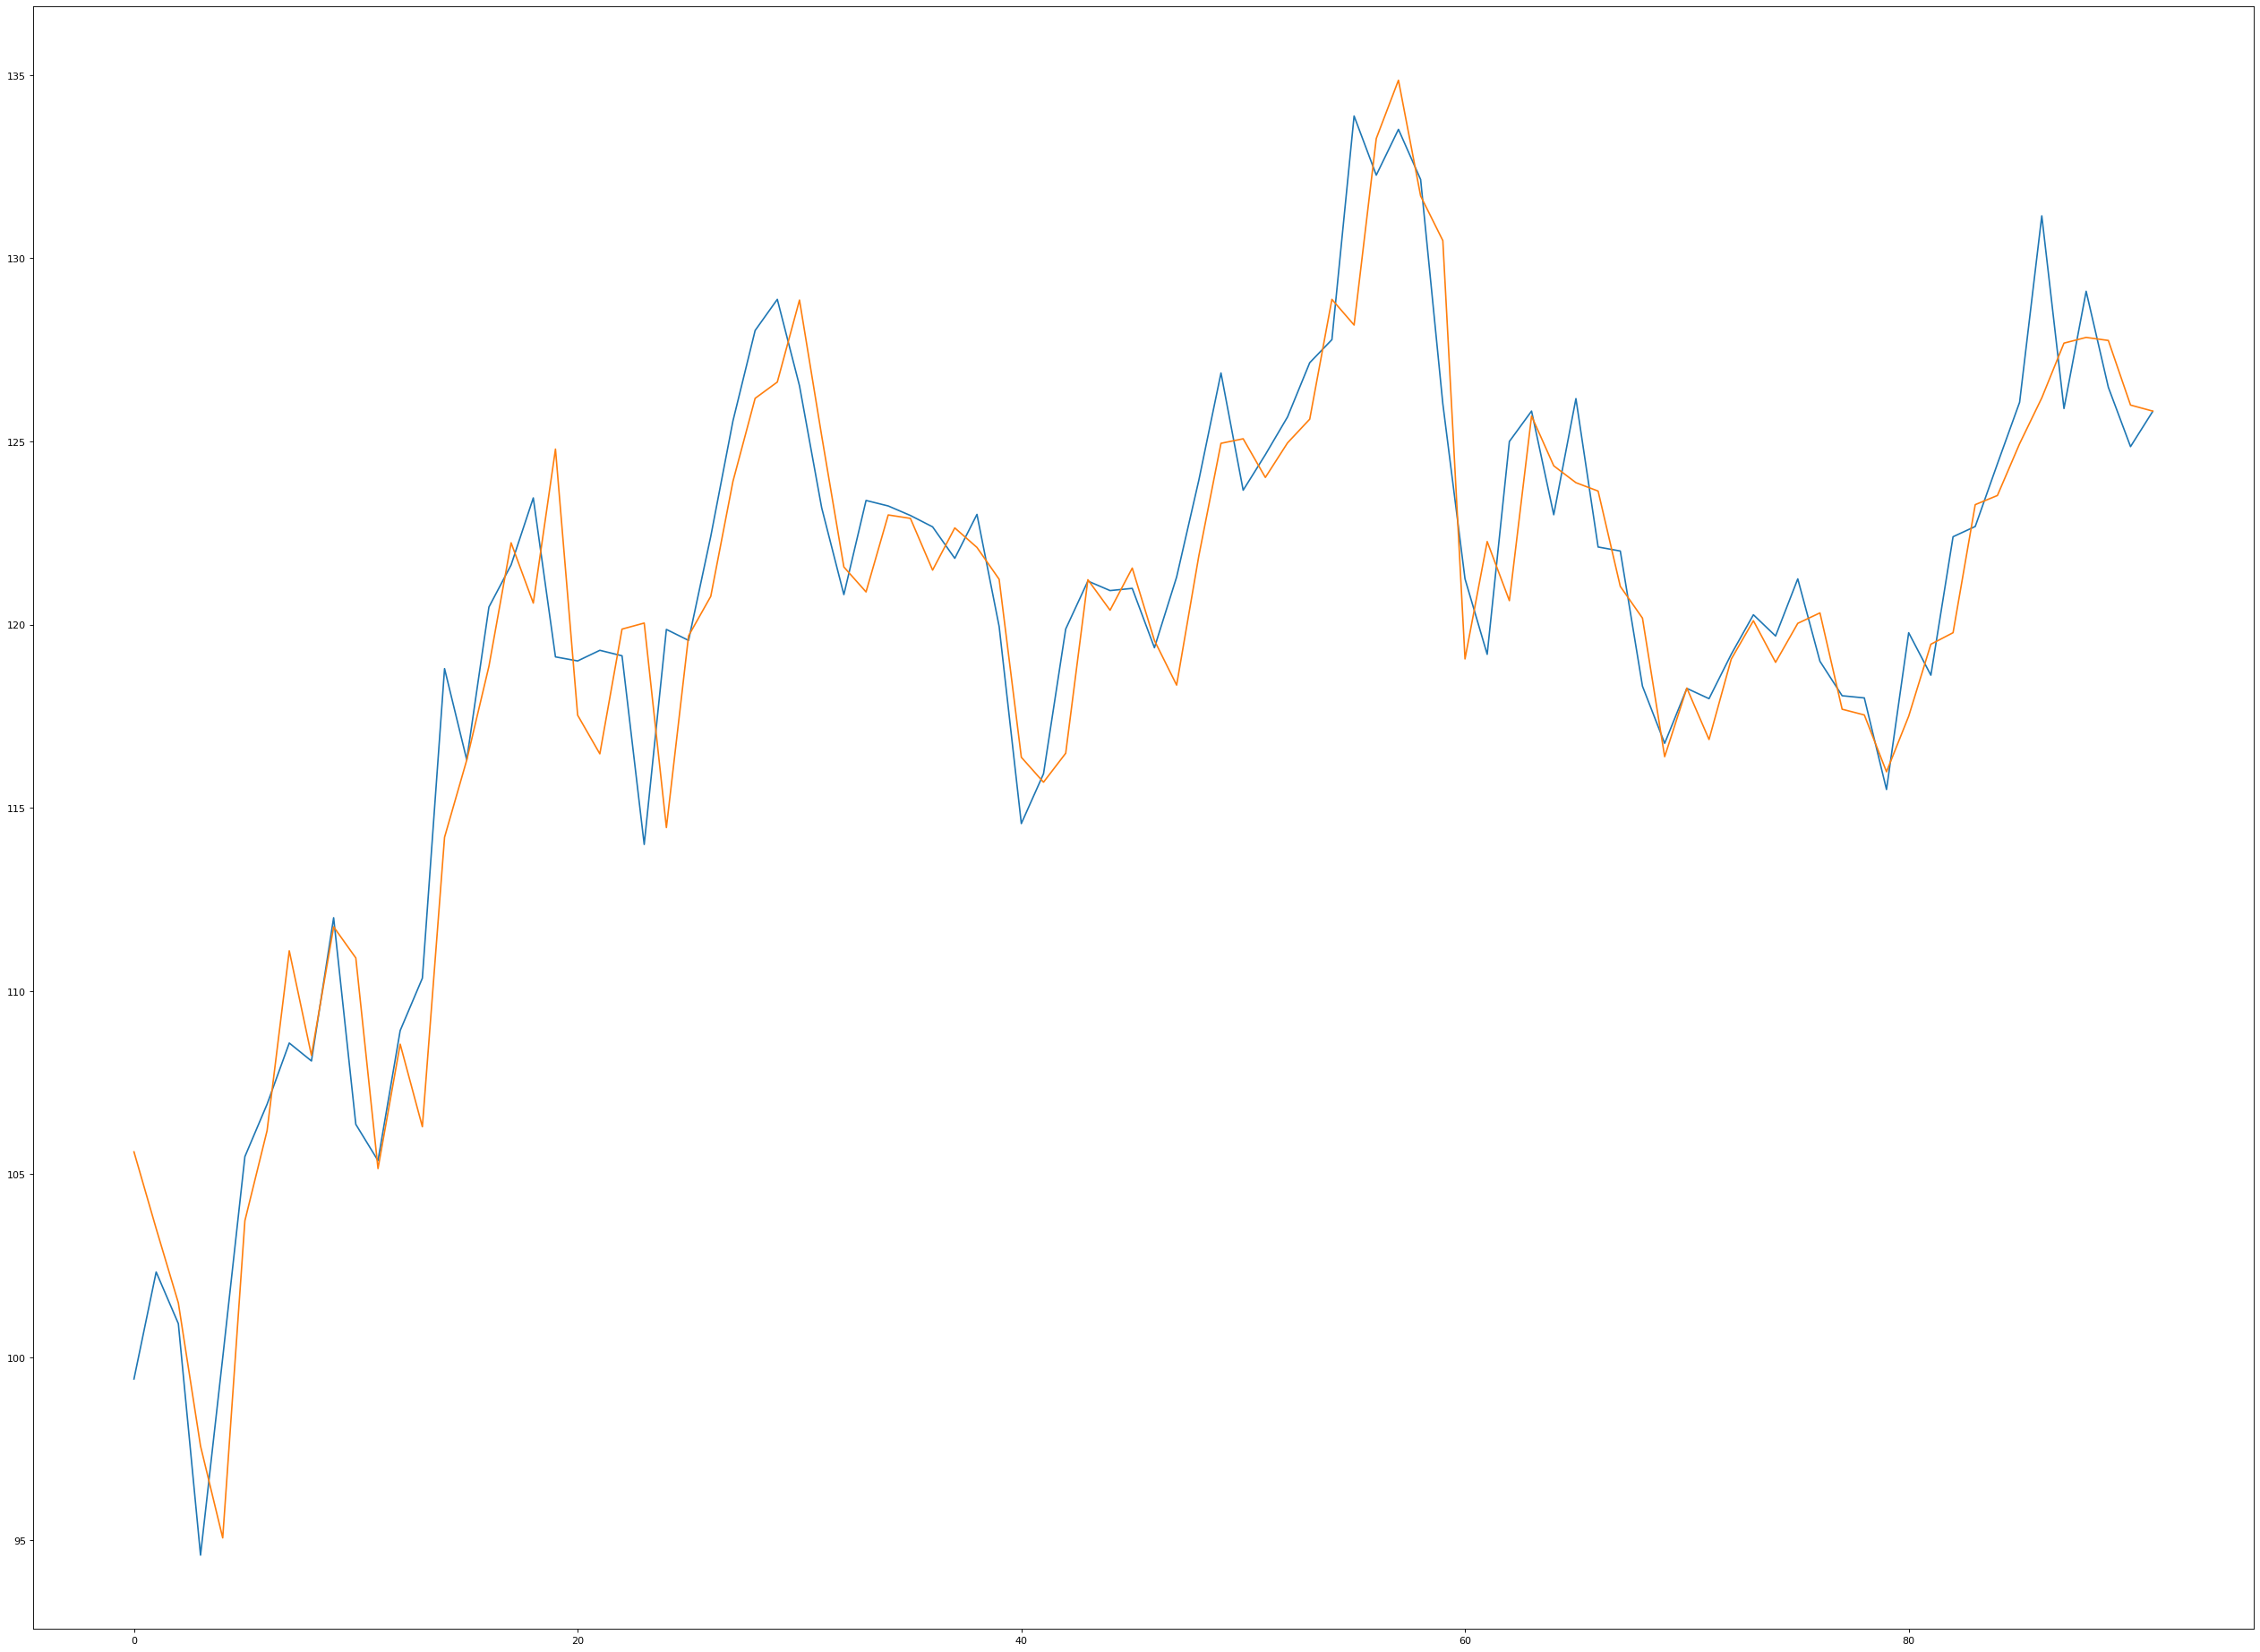

In [58]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(92), unscaled_y_test[-92:])
plt.plot(range(92), predicted_y_test[-92:])
plt.show()